# Data and Target Setup

In [208]:
# control variables
mname = 'xgb1t'
path = './'

In [209]:
import pandas as pd
import numpy as np
import gc, os
import time
import random
import matplotlib.pyplot as plt
import seaborn as sb
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_colwidth', 100)

In [210]:
# main data table, specify D as a missing value for many of the numeric columns
a = pd.read_csv(path+'nuMoM2b_Dataset_NICHD Data Challenge.csv', low_memory=False, na_values='D')
a

PublicID A02_Complete A02_Complete_1 A02_Status A02_Status_1  A02Ver  \
0      00001U     Complete            NaN     Passed          NaN       2   
1      00004O     Complete            NaN     Passed          NaN       2   
2      00007I     Complete            NaN     Passed          NaN       2   
3      00008G     Complete            NaN     Passed          NaN       2   
4      00015J     Complete            NaN     Passed          NaN       2   
...       ...          ...            ...        ...          ...     ...   
9284   17349I     Complete            NaN     Passed          NaN       2   
9285   17350A     Complete            NaN     Passed          NaN       2   
9286   17351V     Complete            NaN     Passed          NaN       2   
9287   17352T     Complete            NaN     Passed          NaN       2   
9288   17354P     Complete            NaN     Passed          NaN       2   

      A02Ver_1  A02DATE_INT  A02DATE_INT_1  A02A01  ...  Unnamed: 11707  \
0          NaN         -197            NaN       1  ...             NaN   
1          NaN         -199            NaN       1  ...             NaN   
2          NaN         -208            NaN       1  ...             NaN   
3          NaN         -205            NaN       1  ...             NaN   
4          NaN         -198            NaN       1  ...             NaN   
...        ...          ...            ...     ...  ...             ...   
9284       NaN         -202            NaN       1  ...             NaN   
9285       NaN         -219            NaN       1  ...             NaN   
9286       NaN         -200            NaN       1  ...             NaN   
9287       NaN         -196            NaN       1  ...             NaN   
9288       NaN         -186            NaN       1  ...             NaN   

     Unnamed: 11708 Unnamed: 11709 Unnamed: 11710 Unnamed: 11711  \
0               NaN            NaN            NaN            NaN   
1               NaN            NaN            NaN            NaN   
2               NaN            NaN            NaN            NaN   
3               NaN            NaN            NaN            NaN   
4               NaN            NaN            NaN            NaN   
...             ...            ...            ...            ...   
9284            NaN            NaN            NaN            NaN   
9285            NaN            NaN            NaN            NaN   
9286            NaN            NaN            NaN            NaN   
9287            NaN            NaN            NaN            NaN   
9288            NaN            NaN            NaN            NaN   

     Unnamed: 11712 Unnamed: 11713 Unnamed: 11714 Unnamed: 11715  \
0               NaN            NaN            NaN            NaN   
1               NaN            NaN            NaN            NaN   
2               NaN            NaN            NaN            NaN   
3               NaN            NaN            NaN            NaN   
4               NaN            NaN            NaN            NaN   
...             ...            ...            ...            ...   
9284            NaN            NaN            NaN            NaN   
9285            NaN            NaN            NaN            NaN   
9286            NaN            NaN            NaN            NaN   
9287            NaN            NaN            NaN            NaN   
9288            NaN            NaN            NaN            NaN   

     Unnamed: 11716  
0               NaN  
1               NaN  
2               NaN  
3               NaN  
4               NaN  
...             ...  
9284            NaN  
9285            NaN  
9286            NaN  
9287            NaN  
9288            NaN  

[9289 rows x 11717 columns]

In [211]:
# create survival target for xgboost, negative values indicate censoring
a['CMDA05A_INT'] = a['CMDA05A_INT'].apply(pd.to_numeric, errors='coerce')
a['CMDA05A_INT'].describe()

count    1988.000000
mean      -21.683099
std        30.949480
min      -143.000000
25%       -30.000000
50%       -11.000000
75%        -1.000000
max        18.000000
Name: CMDA05A_INT, dtype: float64

In [212]:
# missing values here will become right-censored
a.CMDA05A_INT.isnull().value_counts()

True     7301
False    1988
Name: CMDA05A_INT, dtype: int64

In [213]:
# two moms have an event date after second visit date
(a.CMDA05A_INT < a.V2ADATE_INT).sum()

2

In [214]:
# since difference is within one week we keep them
a[(a.CMDA05A_INT < a.V2ADATE_INT)][['CMDA05A_INT','V2ADATE_INT']]

CMDA05A_INT  V2ADATE_INT
2008       -127.0       -126.0
3096       -143.0       -136.0

In [215]:
a.shape

(9289, 11717)

In [216]:
# censor indicator
a['censor'] = a.CMDA05A_INT.isnull().astype(int)
a.censor.describe()

count    9289.000000
mean        0.785983
std         0.410160
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: censor, dtype: float64

In [217]:
# gestational age
a.GAwksCA.describe()

count    8886.000000
mean       38.485483
std         3.402333
min         6.000000
25%        38.000000
50%        39.000000
75%        40.000000
max        43.000000
Name: GAwksCA, dtype: float64

<AxesSubplot:ylabel='Frequency'>

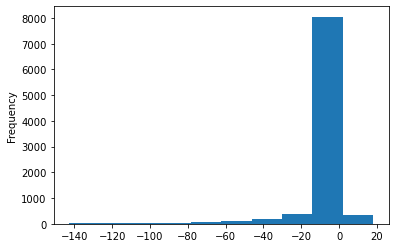

In [218]:
# compute time to event in days relative to gestational age
a['cmda05_days'] = a.CMDA05A_INT.fillna(0) + a.CMDA05a_HR.fillna(0)/24.0 + a.CMDA05a_MIN.fillna(0)/(24.0*60)
a.cmda05_days.plot.hist()

<AxesSubplot:ylabel='Frequency'>

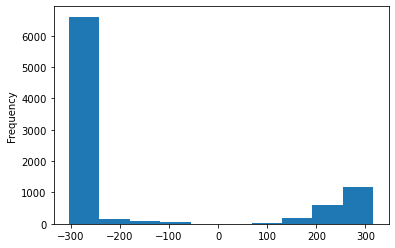

In [219]:
# time _INT variables are measured relative to time of birth
# compute time to hypertension onset in days and relative to gestational age
a['tte'] = (7 * a.GAwksCA + a.GAdysCA + a.cmda05_days)
# set censored values to missing
a['tte2'] = a.tte
a.loc[a.censor==1,'tte2'] = np.nan

# set up negative values for xgboost, indicating they are censored
a['tthd'] = (a.tte)*(1.0 - 2 * a.censor)
a.tthd.plot.hist()

In [220]:
a.tthd.describe()

count    8886.000000
mean     -155.557149
std       219.958845
min      -304.000000
25%      -282.000000
50%      -274.000000
75%      -234.000000
max       316.055556
Name: tthd, dtype: float64

In [221]:
# drop rows with missing target
a = a[a.tthd.notnull()]
a.shape

(8886, 11722)

In [222]:
# drop women with chronic hypertension
a.ChronHTN.value_counts()

2.0    8540
1.0     228
Name: ChronHTN, dtype: int64

In [223]:
a = a[a.ChronHTN != 1.0]
a.shape

(8658, 11722)

In [224]:
target = 'tthd'

### Food Variables

In [225]:
# food variables, use direct numeric values, not one-hots
a_food_onehot = a.loc[:,"FFQ_Date_int":"AHEI2010"].apply(lambda foodCol: pd.to_numeric(foodCol, errors="coerce")).fillna(0)
a_food_onehot

FFQ_Date_int  JAN_PP  FEB_PP  MAR_PP  APR_PP  MAY_PP  JUN_PP  JUL_PP  \
1            234.0     0.0     0.0     1.0     0.0     0.0     0.0     0.0   
2              0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3            205.0     0.0     1.0     1.0     1.0     0.0     0.0     0.0   
4            198.0     0.0     1.0     1.0     1.0     0.0     0.0     0.0   
5            192.0     1.0     1.0     1.0     0.0     0.0     0.0     0.0   
...            ...     ...     ...     ...     ...     ...     ...     ...   
9284         202.0     1.0     1.0     1.0     0.0     0.0     0.0     0.0   
9285         229.0     0.0     0.0     0.0     1.0     1.0     1.0     0.0   
9286         200.0     0.0     0.0     1.0     1.0     1.0     0.0     0.0   
9287         196.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
9288         187.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

      AUG_PP  SEP_PP  ...  AHEI_WGRAINS  AHEI_SUGBEVS  AHEI_NUTLEGS  \
1        0.0     0.0  ...         1.502      0.000000        4.4900   
2        0.0     0.0  ...         0.000      0.000000        0.0000   
3        0.0     0.0  ...         1.186      0.000000        3.3800   
4        0.0     0.0  ...         1.002      5.366402       10.0000   
5        0.0     0.0  ...         0.428      0.000000        0.5350   
...      ...     ...  ...           ...           ...           ...   
9284     0.0     0.0  ...         0.860      0.000000        3.1650   
9285     0.0     0.0  ...         0.816      0.000000        0.4909   
9286     0.0     0.0  ...         0.294      9.155644        3.5790   
9287     0.0     0.0  ...         1.956      0.000000        5.9600   
9288     0.0     1.0  ...         0.562      0.000000        4.3000   

      AHEI_RMEATS  AHEI_TRFATPCT  AHEI_DHAEPA  AHEI_PUFAPCT  AHEI_SODIUM  \
1        6.162236       7.478604        7.360      9.020737     6.962302   
2        0.000000       0.000000        0.000      0.000000     0.000000   
3        6.564417       7.673692        0.936      6.294495     6.954905   
4        5.310157       9.430597        5.400     10.000000     0.000000   
5        6.768916       7.119453        1.700     10.000000     9.910997   
...           ...            ...          ...           ...          ...   
9284     4.669393       8.982259        3.596      4.476044     5.179470   
9285     1.567825       7.280527        1.052      8.100696     9.633505   
9286     8.588957       9.874415        3.496      6.962957    10.000000   
9287     7.600545       8.367089        9.040      8.911255     9.068236   
9288     5.501022       9.063648        2.152      9.032943     6.730854   

      AHEI_ALCDRKS   AHEI2010  
1              2.5  52.410880  
2              0.0   0.000000  
3              5.0  53.209509  
4              5.0  70.084156  
5             10.0  48.539366  
...            ...        ...  
9284           2.5  40.753166  
9285           5.0  38.578954  
9286           5.0  61.258473  
9287          10.0  68.488125  
9288           2.5  42.594468  

[8658 rows x 733 columns]

<AxesSubplot:ylabel='Frequency'>

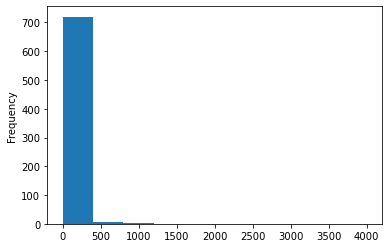

In [226]:
a_food_onehot.mean().plot.hist()

### One-Hot Encoding for Drugs

In [227]:
data = a
data.columns[data.columns.str.startswith("VXXC01g")]

Index(['VXXC01g', 'VXXC01g_1', 'VXXC01g_2', 'VXXC01g_3', 'VXXC01g_4',
       'VXXC01g_5', 'VXXC01g_6', 'VXXC01g_7', 'VXXC01g_8', 'VXXC01g_9',
       'VXXC01g_10', 'VXXC01g_11', 'VXXC01g_12', 'VXXC01g_13', 'VXXC01g_14',
       'VXXC01g_15', 'VXXC01g_16', 'VXXC01g_17', 'VXXC01g_18', 'VXXC01g_19',
       'VXXC01g_20', 'VXXC01g_21', 'VXXC01g_22', 'VXXC01g_23', 'VXXC01g_24',
       'VXXC01g_25', 'VXXC01g_26', 'VXXC01g_27', 'VXXC01g_001', 'VXXC01g_002',
       'VXXC01g_003', 'VXXC01g_004', 'VXXC01g_005', 'VXXC01g_006',
       'VXXC01g_007', 'VXXC01g_008', 'VXXC01g_009', 'VXXC01g_010',
       'VXXC01g_011', 'VXXC01g_012', 'VXXC01g_013', 'VXXC01g_014',
       'VXXC01g_015', 'VXXC01g_016', 'VXXC01g_017', 'VXXC01g_018',
       'VXXC01g_019', 'VXXC01g_020', 'VXXC01g_021', 'VXXC01g_022',
       'VXXC01g_023', 'VXXC01g_024', 'VXXC01g_025', 'VXXC01g_026',
       'VXXC01g_027', 'VXXC01g_028', 'VXXC01g_029', 'VXXC01g_030',
       'VXXC01g_031', 'VXXC01g_032', 'VXXC01g_033', 'VXXC01g_034',
       'VXXC

In [228]:
data_info = pd.read_excel(path+'nuMoM2b_Codebook_NICHD Data Challenge.xlsx', header=1)
vxx_info = data_info[data_info["Variable Name"].str.startswith("VXXC01g")]
vxx_info 

Original Dataset Name Variable Name  \
3926     drugs_in_pregnancy       VXXC01g   
3927     drugs_in_pregnancy     VXXC01g_1   
3928     drugs_in_pregnancy     VXXC01g_2   
3929     drugs_in_pregnancy     VXXC01g_3   
3930     drugs_in_pregnancy     VXXC01g_4   
...                     ...           ...   
11565                   vxx   VXXC01g_041   
11576                   vxx   VXXC01g_042   
11587                   vxx   VXXC01g_043   
11598                   vxx   VXXC01g_044   
11609                   vxx   VXXC01g_045   

                                               Variable Label Variable Type  \
3926        (VXX) Medications and vaccinations - Start timing         Coded   
3927        (VXX) Medications and vaccinations - Start timing         Coded   
3928        (VXX) Medications and vaccinations - Start timing         Coded   
3929        (VXX) Medications and vaccinations - Start timing         Coded   
3930        (VXX) Medications and vaccinations - Start timing         Coded   
...                                                       ...           ...   
11565  (VXX) Medications and vaccinations (41) - Start timing         Coded   
11576  (VXX) Medications and vaccinations (42) - Start timing         Coded   
11587  (VXX) Medications and vaccinations (43) - Start timing         Coded   
11598  (VXX) Medications and vaccinations (44) - Start timing         Coded   
11609  (VXX) Medications and vaccinations (45) - Start timing         Coded   

      Variable Unit\n(if Numeric) Variable Code List\n(if Coded)  
3926                          NaN                    Drug_Timing  
3927                          NaN                    Drug_Timing  
3928                          NaN                    Drug_Timing  
3929                          NaN                    Drug_Timing  
3930                          NaN                    Drug_Timing  
...                           ...                            ...  
11565                         NaN                    Drug_Timing  
11576                         NaN                    Drug_Timing  
11587                         NaN                    Drug_Timing  
11598                         NaN                    Drug_Timing  
11609                         NaN                    Drug_Timing  

[73 rows x 6 columns]

In [229]:
vxx_info[vxx_info["Original Dataset Name"] == "vxx"]

Original Dataset Name Variable Name  \
11125                   vxx   VXXC01g_001   
11136                   vxx   VXXC01g_002   
11147                   vxx   VXXC01g_003   
11158                   vxx   VXXC01g_004   
11169                   vxx   VXXC01g_005   
...                     ...           ...   
11565                   vxx   VXXC01g_041   
11576                   vxx   VXXC01g_042   
11587                   vxx   VXXC01g_043   
11598                   vxx   VXXC01g_044   
11609                   vxx   VXXC01g_045   

                                               Variable Label Variable Type  \
11125   (VXX) Medications and vaccinations (1) - Start timing         Coded   
11136   (VXX) Medications and vaccinations (2) - Start timing         Coded   
11147   (VXX) Medications and vaccinations (3) - Start timing         Coded   
11158   (VXX) Medications and vaccinations (4) - Start timing         Coded   
11169   (VXX) Medications and vaccinations (5) - Start timing         Coded   
...                                                       ...           ...   
11565  (VXX) Medications and vaccinations (41) - Start timing         Coded   
11576  (VXX) Medications and vaccinations (42) - Start timing         Coded   
11587  (VXX) Medications and vaccinations (43) - Start timing         Coded   
11598  (VXX) Medications and vaccinations (44) - Start timing         Coded   
11609  (VXX) Medications and vaccinations (45) - Start timing         Coded   

      Variable Unit\n(if Numeric) Variable Code List\n(if Coded)  
11125                         NaN                    Drug_Timing  
11136                         NaN                    Drug_Timing  
11147                         NaN                    Drug_Timing  
11158                         NaN                    Drug_Timing  
11169                         NaN                    Drug_Timing  
...                           ...                            ...  
11565                         NaN                    Drug_Timing  
11576                         NaN                    Drug_Timing  
11587                         NaN                    Drug_Timing  
11598                         NaN                    Drug_Timing  
11609                         NaN                    Drug_Timing  

[45 rows x 6 columns]

In [230]:
vxx_info[vxx_info["Original Dataset Name"] == "drugs_in_pregnancy"]

Original Dataset Name Variable Name  \
3926    drugs_in_pregnancy       VXXC01g   
3927    drugs_in_pregnancy     VXXC01g_1   
3928    drugs_in_pregnancy     VXXC01g_2   
3929    drugs_in_pregnancy     VXXC01g_3   
3930    drugs_in_pregnancy     VXXC01g_4   
...                    ...           ...   
3949    drugs_in_pregnancy    VXXC01g_23   
3950    drugs_in_pregnancy    VXXC01g_24   
3951    drugs_in_pregnancy    VXXC01g_25   
3952    drugs_in_pregnancy    VXXC01g_26   
3953    drugs_in_pregnancy    VXXC01g_27   

                                         Variable Label Variable Type  \
3926  (VXX) Medications and vaccinations - Start timing         Coded   
3927  (VXX) Medications and vaccinations - Start timing         Coded   
3928  (VXX) Medications and vaccinations - Start timing         Coded   
3929  (VXX) Medications and vaccinations - Start timing         Coded   
3930  (VXX) Medications and vaccinations - Start timing         Coded   
...                                                 ...           ...   
3949  (VXX) Medications and vaccinations - Start timing         Coded   
3950  (VXX) Medications and vaccinations - Start timing         Coded   
3951  (VXX) Medications and vaccinations - Start timing         Coded   
3952  (VXX) Medications and vaccinations - Start timing         Coded   
3953  (VXX) Medications and vaccinations - Start timing         Coded   

     Variable Unit\n(if Numeric) Variable Code List\n(if Coded)  
3926                         NaN                    Drug_Timing  
3927                         NaN                    Drug_Timing  
3928                         NaN                    Drug_Timing  
3929                         NaN                    Drug_Timing  
3930                         NaN                    Drug_Timing  
...                          ...                            ...  
3949                         NaN                    Drug_Timing  
3950                         NaN                    Drug_Timing  
3951                         NaN                    Drug_Timing  
3952                         NaN                    Drug_Timing  
3953                         NaN                    Drug_Timing  

[28 rows x 6 columns]

In [231]:
dataset_info = pd.read_excel(path+'nuMoM2b Dataset Information.xlsx', header=2)
dataset_info[dataset_info["Dataset Name"].isin(["vxx", "drugs_in_pregnancy"])]

No.        Dataset Name  \
35   36  drugs_in_pregnancy   
78   79                 vxx   

                                                             Dataset Title  \
35  nuMoM2b Medications Used During Pregnancy [Drugs in Pregnancy] Dataset   
78                nuMoM2b Medical Conditions and Medications [VXX] Dataset   

                                                                                              Keywords  \
35                                                                    Drugs; Medications; Vaccinations   
78  Medical conditions; Diagnosis; Chart abstraction; Medications; Vaccinations; Vitamins; Supplements   

    Total # of Columns  Total # of Rows  \
35                  16            40438   
78                 984             9023   

                        Corresponding Case Report Form (CRF) Name  \
35  nuMoM2b_VXX_Medical Conditions and Medications_2011-12-09.pdf   
78  nuMoM2b_VXX_Medical Conditions and Medications_2011-12-09.pdf   

   CRF Study Timepoint  \
35           Ancillary   
78       Across Visits   

                                                                              CRF Section Heading Names  \
35  5.13.8 Drugs_in_Pregnancy: Medications Used During Pregnancy\n\nSee documentation: nuMoM2b-Datab...   
78                A. Administration and Verification\nB. Medical Conditions / Diagnoses\nC. Medications   

   Relevance to Maternal Morbidity (Y/N)  \
35                                     Y   
78                                     Y   

                                                                                               Comments  
35  Contains the standardized and corrected medication data (i.e., standardized medication names, co...  
78                                                 Pre-existing health conditions and medications taken

In [232]:
# VXX variables code the time the drug was taken
vxxc01g_vars = vxx_info[vxx_info["Original Dataset Name"] == "drugs_in_pregnancy"]["Variable Name"].values
vxxc01g_vars

array(['VXXC01g', 'VXXC01g_1', 'VXXC01g_2', 'VXXC01g_3', 'VXXC01g_4',
       'VXXC01g_5', 'VXXC01g_6', 'VXXC01g_7', 'VXXC01g_8', 'VXXC01g_9',
       'VXXC01g_10', 'VXXC01g_11', 'VXXC01g_12', 'VXXC01g_13',
       'VXXC01g_14', 'VXXC01g_15', 'VXXC01g_16', 'VXXC01g_17',
       'VXXC01g_18', 'VXXC01g_19', 'VXXC01g_20', 'VXXC01g_21',
       'VXXC01g_22', 'VXXC01g_23', 'VXXC01g_24', 'VXXC01g_25',
       'VXXC01g_26', 'VXXC01g_27'], dtype=object)

In [233]:
# we want to drop all cases coded 4, 5, or nan, since our target is assessed on or before the second visit
for col in vxxc01g_vars:
    print(data[col].unique())

[ 1.  3. nan  2.  4.  5.  6.]
[ 1.  4. nan  3.  5.  2.  6.]
[ 3.  4. nan  1.  5.  6.  2.]
[ 1.  3.  5. nan  2.  4.  6.]
[ 1.  4. nan  3.  5.  6.  2.]
[ 6.  4. nan  1.  5.  3.  2.]
[ 6. nan  1.  5.  4.  3.  2.]
[nan  1.  4.  6.  5.  3.  2.]
[nan  1.  6.  3.  2.  5.  4.]
[nan  1.  2.  3.  5.  6.  4.]
[nan  4.  3.  2.  6.  5.  1.]
[nan  3.  5.  6.  2.  4.  1.]
[nan  4.  2.  5.  6.  1.  3.]
[nan  5.  2.  6.  3.  4.  1.]
[nan  2.  6.  1.  5.  3.  4.]
[nan  5.  6.  3.  1.  4.]
[nan  5.  4.  1.  6.  3.]
[nan  5.  6.  1.  4.  2.  3.]
[nan  5.  1.  4.  2.  6.  3.]
[nan  5.  3.  1.  4.  6.]
[nan  5.  4.  1.  6.  3.  2.]
[nan  5.  1.  6.  2.]
[nan  6.  5.  2.]
[nan  6.  5.  1.]
[nan  5.  6.  4.]
[nan  6.  5.]
[nan  5.]
[nan  6.  5.]


In [234]:
data[vxxc01g_vars] = data[vxxc01g_vars].fillna(7.0)

In [235]:
for col in vxxc01g_vars:
    print(data[col].unique()) # convert nan value to 7 for convenience in comparisons 

[1. 3. 7. 2. 4. 5. 6.]
[1. 4. 7. 3. 5. 2. 6.]
[3. 4. 7. 1. 5. 6. 2.]
[1. 3. 5. 7. 2. 4. 6.]
[1. 4. 7. 3. 5. 6. 2.]
[6. 4. 7. 1. 5. 3. 2.]
[6. 7. 1. 5. 4. 3. 2.]
[7. 1. 4. 6. 5. 3. 2.]
[7. 1. 6. 3. 2. 5. 4.]
[7. 1. 2. 3. 5. 6. 4.]
[7. 4. 3. 2. 6. 5. 1.]
[7. 3. 5. 6. 2. 4. 1.]
[7. 4. 2. 5. 6. 1. 3.]
[7. 5. 2. 6. 3. 4. 1.]
[7. 2. 6. 1. 5. 3. 4.]
[7. 5. 6. 3. 1. 4.]
[7. 5. 4. 1. 6. 3.]
[7. 5. 6. 1. 4. 2. 3.]
[7. 5. 1. 4. 2. 6. 3.]
[7. 5. 3. 1. 4. 6.]
[7. 5. 4. 1. 6. 3. 2.]
[7. 5. 1. 6. 2.]
[7. 6. 5. 2.]
[7. 6. 5. 1.]
[7. 5. 6. 4.]
[7. 6. 5.]
[7. 5.]
[7. 6. 5.]


Note that there are vxxc01g columns whose values are all above 4. 

In [236]:
# total number of invalid drug values
total = 0 
for col in vxxc01g_vars:
    total += (data[col]>4).sum()
print(total)

213155


In [237]:
# drug columns 
drug_vars = data.columns[data.columns.str.startswith("DrugName")].values 

In [238]:
vxx_drug_pair = dict(zip(drug_vars, vxxc01g_vars))
vxx_drug_pair

{'DrugName': 'VXXC01g',
 'DrugName_1': 'VXXC01g_1',
 'DrugName_2': 'VXXC01g_2',
 'DrugName_3': 'VXXC01g_3',
 'DrugName_4': 'VXXC01g_4',
 'DrugName_5': 'VXXC01g_5',
 'DrugName_6': 'VXXC01g_6',
 'DrugName_7': 'VXXC01g_7',
 'DrugName_8': 'VXXC01g_8',
 'DrugName_9': 'VXXC01g_9',
 'DrugName_10': 'VXXC01g_10',
 'DrugName_11': 'VXXC01g_11',
 'DrugName_12': 'VXXC01g_12',
 'DrugName_13': 'VXXC01g_13',
 'DrugName_14': 'VXXC01g_14',
 'DrugName_15': 'VXXC01g_15',
 'DrugName_16': 'VXXC01g_16',
 'DrugName_17': 'VXXC01g_17',
 'DrugName_18': 'VXXC01g_18',
 'DrugName_19': 'VXXC01g_19',
 'DrugName_20': 'VXXC01g_20',
 'DrugName_21': 'VXXC01g_21',
 'DrugName_22': 'VXXC01g_22',
 'DrugName_23': 'VXXC01g_23',
 'DrugName_24': 'VXXC01g_24',
 'DrugName_25': 'VXXC01g_25',
 'DrugName_26': 'VXXC01g_26',
 'DrugName_27': 'VXXC01g_27'}

In [239]:
# replace the invalid drug values, whose corresponding vxxc01g column value is above 4, with arbitrary value "fake"
# for convenience in creating onehot variable 
for drug, vxxc01g in vxx_drug_pair.items():
    data[drug] = data.apply(lambda row: "fake" if row[vxxc01g] > 4 else row[drug], axis=1)

In [240]:
data.shape

(8658, 11722)

In [241]:
# total number of invalid drug values being identified 
total = 0 
for drug in vxx_drug_pair.keys():
    total += (data[drug] == "fake").sum()
print(total) # which is equivalent to the total number of invalid drug values calculated previously 

213155


In [242]:
# check how many unique drug names in all the drug name columns 
drug_union = pd.unique(data[data.columns[data.columns.str.startswith("DrugName")]].values.ravel("K"))
len(drug_union) # 565 real drug names plus "fake"

552

In [243]:
print(drug_union) 
# note that nan is one of the drug names, so the real drug name number should be 624

['IBUPROFEN' 'FLUTICASONE' 'PRENATAL VITAMIN' 'LEVOTHYROXINE' 'ADDERALL'
 'fake' 'SERTRALINE' 'VITAMIN D' 'UNKNOWN' 'ACYCLOVIR' 'NAPROXEN'
 'INFLUENZA VACCINE' 'OCP' 'ALBUTEROL' 'TOPIRAMATE' 'ERYTHROMYCIN'
 'TETANUS VACCINE' 'RANITIDINE' 'DHA' 'FLUCONAZOLE' 'IRON'
 'ACETAMINOPHEN/OXYCODONE' 'PENICILLIN' 'PPD' 'ACETAMINOPHEN' 'CETIRIZINE'
 'ENOXAPARIN' 'METFORMIN' 'PROMETHAZINE' 'CEPHALEXIN' 'ONDANSETRON'
 'METHYLDOPA' 'ASPIRIN/ACETAMINOPHEN/CAFFEINE' 'METRONIDAZOLE'
 'CITALOPRAM' 'NITROFURANTOIN' 'FOLIC ACID' 'ASPIRIN' 'LACTULOSE'
 'BUPRENORPHINE/NALOXONE' 'LORATADINE' 'PREDNISONE' 'OMEPRAZOLE'
 'LISDEXAMFETAMINE' 'ESTROGEN' 'AZELAIC ACID' 'BUPROPION' 'FLUOXETINE'
 'HYDROXYCHLOROQUINE' 'AMOXICILLIN' 'MULTIVITAMIN' 'MICONAZOLE'
 'LEVETIRACETAM' 'VERAPAMIL' 'MESALAMINE' 'VITAMIN B-6' 'AZITHROMYCIN'
 'RIZATRIPTAN' 'INSULIN' 'ZOLPIDEM' 'CALCIUM' 'DESVENLAFAXINE' 'LABETALOL'
 'MONTELUKAST' 'METOCLOPRAMIDE' 'DOXYCYCLINE' 'CLOMIPHENE' 'VALACYCLOVIR'
 'FISH OIL' 'FEXOFENADINE/PSEUDOEPHEDRINE' 

In [244]:
drugs_onehot_data = pd.get_dummies(data[data.columns[data.columns.str.startswith("DrugName")]], prefix="DrugName").max(axis=1, level=0)
drugs_onehot_data

DrugName_ACETAMINOPHEN  DrugName_ACETAMINOPHEN/BUTALBITAL/CAFFEINE  \
1                          0                                           0   
2                          0                                           0   
3                          1                                           0   
4                          0                                           0   
5                          0                                           0   
...                      ...                                         ...   
9284                       0                                           0   
9285                       0                                           0   
9286                       0                                           0   
9287                       0                                           0   
9288                       0                                           0   

      DrugName_ACETAMINOPHEN/CAFFEINE  DrugName_ACETAMINOPHEN/CODEINE  \
1                                   0                               0   
2                                   0                               0   
3                                   0                               0   
4                                   0                               0   
5                                   0                               0   
...                               ...                             ...   
9284                                0                               0   
9285                                0                               0   
9286                                0                               0   
9287                                0                               0   
9288                                0                               0   

      DrugName_ACETAMINOPHEN/DIPHENHYDRAMINE  \
1                                          0   
2                                          0   
3                                          0   
4                                          0   
5                                          0   
...                                      ...   
9284                                       0   
9285                                       0   
9286                                       0   
9287                                       0   
9288                                       0   

      DrugName_ACETAMINOPHEN/HYDROCODONE  DrugName_ACETAMINOPHEN/OXYCODONE  \
1                                      0                                 0   
2                                      0                                 0   
3                                      1                                 0   
4                                      0                                 0   
5                                      0                                 0   
...                                  ...                               ...   
9284                                   0                                 0   
9285                                   0                                 0   
9286                                   0                                 0   
9287                                   0                                 0   
9288                                   0                                 0   

      DrugName_ACYCLOVIR  DrugName_ADALIMUMAB  DrugName_ADDERALL  ...  \
1                      0                    0                  0  ...   
2                      0                    0                  0  ...   
3                      0                    0                  0  ...   
4                      0                    0                  0  ...   
5                      0                    0                  0  ...   
...                  ...                  ...                ...  ...   
9284                   0                    0                  0  ...   
9285                   0                    0                  0  ...   
9286                   0                    0

In [245]:
len(drugs_onehot_data.columns) # consistent with the unique drug numbers 

552

In [246]:
drugs_onehot_data = drugs_onehot_data.drop(columns=["DrugName_fake"])

In [247]:
len(drugs_onehot_data.columns)

551

In [248]:
a_drug_onehot = drugs_onehot_data
a_drug_onehot

DrugName_ACETAMINOPHEN  DrugName_ACETAMINOPHEN/BUTALBITAL/CAFFEINE  \
1                          0                                           0   
2                          0                                           0   
3                          1                                           0   
4                          0                                           0   
5                          0                                           0   
...                      ...                                         ...   
9284                       0                                           0   
9285                       0                                           0   
9286                       0                                           0   
9287                       0                                           0   
9288                       0                                           0   

      DrugName_ACETAMINOPHEN/CAFFEINE  DrugName_ACETAMINOPHEN/CODEINE  \
1                                   0                               0   
2                                   0                               0   
3                                   0                               0   
4                                   0                               0   
5                                   0                               0   
...                               ...                             ...   
9284                                0                               0   
9285                                0                               0   
9286                                0                               0   
9287                                0                               0   
9288                                0                               0   

      DrugName_ACETAMINOPHEN/DIPHENHYDRAMINE  \
1                                          0   
2                                          0   
3                                          0   
4                                          0   
5                                          0   
...                                      ...   
9284                                       0   
9285                                       0   
9286                                       0   
9287                                       0   
9288                                       0   

      DrugName_ACETAMINOPHEN/HYDROCODONE  DrugName_ACETAMINOPHEN/OXYCODONE  \
1                                      0                                 0   
2                                      0                                 0   
3                                      1                                 0   
4                                      0                                 0   
5                                      0                                 0   
...                                  ...                               ...   
9284                                   0                                 0   
9285                                   0                                 0   
9286                                   0                                 0   
9287                                   0                                 0   
9288                                   0                                 0   

      DrugName_ACYCLOVIR  DrugName_ADALIMUMAB  DrugName_ADDERALL  ...  \
1                      0                    0                  0  ...   
2                      0                    0                  0  ...   
3                      0                    0                  0  ...   
4                      0                    0                  0  ...   
5                      0                    0                  0  ...   
...                  ...                  ...                ...  ...   
9284                   0                    0                  0  ...   
9285                   0                    0                  0  ...   
9286                   0                    0

In [249]:
# data_with_food_drug_onehot.to_csv("../data/data_with_food_drug_onehot.csv")

<AxesSubplot:ylabel='Frequency'>

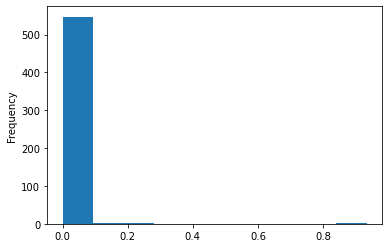

In [250]:
a_drug_onehot.mean().plot.hist()

### Feature Labels

In [251]:
# !pip install xlrd
# !pip install openpyxl

In [252]:
# column groups
b = pd.read_excel(path+'nuMoM2b Dataset Information.xlsx', header=2)
b

No. Dataset Name  \
0     1          a02   
1     2          a03   
2     3          a04   
3     4          a05   
4     5          a09   
..  ...          ...   
74   75          v3j   
75   76          v3k   
76   77          v3l   
77   78          v4a   
78   79          vxx   

                                                           Dataset Title  \
0                              nuMoM2b Elements of Consent [A02] Dataset   
1                              nuMoM2b Protocol Deviations [A03] Dataset   
2                                    nuMoM2b Adverse Event [A04] Dataset   
3                                 nuMoM2b Study Withdrawal [A05] Dataset   
4                nuMoM2b Brief Report of Pregnancy Outcome [A09] Dataset   
..                                                                   ...   
74  nuMoM2b Brief Pregnancy Experience Scale (PES) Visit 3 [V3J] Dataset   
75              nuMoM2b Sleep Monitoring Following Visit 3 [V3K] Dataset   
76             nuMoM2b Revised Sleep Questionnaire Visit 3 [V3L] Dataset   
77                     nuMoM2b Delivery Maternal Interview [V4A] Dataset   
78              nuMoM2b Medical Conditions and Medications [VXX] Dataset   

                                                                                              Keywords  \
0                                                                             Informed consent; Assent   
1                                                                                   Protocol deviation   
2                                                                                        Adverse event   
3                                                              Study withdrawal; Study discontinuation   
4                                                                     Pregnancy outcome; Complications   
..                                                                                                 ...   
74                                                                                  Feelings; Emotions   
75                                             Sleep time; Sleep length; Sleep position; Sleep quality   
76                                  Sleep habits; Snoring; Sleep issues; Sleep quality; Sleep position   
77       Hospital; Labor; Induction; Cesarean section; Illnesses; Activity restriction; Substance use    
78  Medical conditions; Diagnosis; Chart abstraction; Medications; Vaccinations; Vitamins; Supplements   

    Total # of Columns  Total # of Rows  \
0                   32             9290   
1                   18              301   
2                   14               72   
3                   27              304   
4                   18             9216   
..                 ...              ...   
74                  26             8181   
75                  30             2450   
76                  66             7816   
77                 137             6662   
78                 984             9023   

                                             Corresponding Case Report Form (CRF) Name  \
0                                       nuMoM2b_A02_Elements of Consent_2010-09-27.pdf   
1                                       nuMoM2b_A03_Protocol Deviations_2010-09-27.pdf   
2                                             nuMoM2b_A04_Adverse Event_2010-09-27.pdf   
3                                          nuMoM2b_A05_Study Withdrawal_2010-09-27.pdf   
4                               nuMoM2b_A09_Report of Pregnancy Outcome_2012-02-16.pdf   
..                                                                                 ...   
74  nuMoM2b_V3J_Brief Pregnancy Experience Scale (PES) Visit 3_2010-09-27_redacted.pdf   
75          nuMoM2b_V3K_Portable Sleep Assessment Questionnaire Visit 3_2011-01-17.pdf   
76             nuMoM2b_V3L_Revised Sleep Questionnaire Visit 3_2011-01-17_redacted.pdf   
77                              nuMoM2b_V4A_Maternal_Interview Delivery_2011-12-09.pdf   
78                    

In [253]:
# column labels
c = pd.read_excel(path+'nuMoM2b_Codebook_NICHD Data Challenge.xlsx', header=1)
c

Original Dataset Name   Variable Name  \
0                       NaN        PublicID   
1                       a02    A02_Complete   
2                       a02  A02_Complete_1   
3                       a02      A02_Status   
4                       a02    A02_Status_1   
...                     ...             ...   
11612                   vxx     VXXC01j_045   
11613                   vxx     VXXC01k_045   
11614                   vxx         VXXC02a   
11615                   vxx         VXXC02b   
11616                   vxx         VXXC02c   

                                                                                            Variable Label  \
0                                                                                        Public nuMoM2b ID   
1                                                                                  (A02) Data entry status   
2                                                                                  (A02) Data entry status   
3                                                                                  (A02) Validation status   
4                                                                                  (A02) Validation status   
...                                                                                                    ...   
11612                       (VXX) Medications and vaccinations (45) - Source: Chart abstraction (checkbox)   
11613       (VXX) Medications and vaccinations (45) - Final assessment: Took medication/vaccine (checkbox)   
11614  (VXX) How long have you been taking [perinatal vitamins/other multivitamins/ folate supplements]...   
11615  (VXX) How long have you been taking [perinatal vitamins/other multivitamins/ folate supplements]...   
11616  (VXX) How long have you been taking [perinatal vitamins/other multivitamins/ folate supplements]...   

      Variable Type Variable Unit\n(if Numeric) Variable Code List\n(if Coded)  
0         Character                         NaN                            NaN  
1         Character                         NaN                            NaN  
2         Character                         NaN                            NaN  
3         Character                         NaN                            NaN  
4         Character                         NaN                            NaN  
...             ...                         ...                            ...  
11612         Coded                         NaN                        Checked  
11613         Coded                         NaN                        Checked  
11614       Numeric                       Weeks                            NaN  
11615       Numeric                      Months                            NaN  
11616       Numeric                       Years                            NaN  

[11617 rows x 6 columns]

In [254]:
clab = c[['Original Dataset Name', 'Variable Name','Variable Label']]
clab.columns = ['dataset','feature','label']
clab = clab.set_index('feature')
clab

dataset  \
feature                  
PublicID           NaN   
A02_Complete       a02   
A02_Complete_1     a02   
A02_Status         a02   
A02_Status_1       a02   
...                ...   
VXXC01j_045        vxx   
VXXC01k_045        vxx   
VXXC02a            vxx   
VXXC02b            vxx   
VXXC02c            vxx   

                                                                                                              label  
feature                                                                                                              
PublicID                                                                                          Public nuMoM2b ID  
A02_Complete                                                                                (A02) Data entry status  
A02_Complete_1                                                                              (A02) Data entry status  
A02_Status                                                                                  (A02) Validation status  
A02_Status_1                                                                                (A02) Validation status  
...                                                                                                             ...  
VXXC01j_045                          (VXX) Medications and vaccinations (45) - Source: Chart abstraction (checkbox)  
VXXC01k_045          (VXX) Medications and vaccinations (45) - Final assessment: Took medication/vaccine (checkbox)  
VXXC02a         (VXX) How long have you been taking [perinatal vitamins/other multivitamins/ folate supplements]...  
VXXC02b         (VXX) How long have you been taking [perinatal vitamins/other multivitamins/ folate supplements]...  
VXXC02c         (VXX) How long have you been taking [perinatal vitamins/other multivitamins/ folate supplements]...  

[11617 rows x 2 columns]

In [255]:
# column codes
c1 = pd.read_excel(path+'nuMoM2b_Codebook_NICHD Data Challenge.xlsx', sheet_name=1)
c1

Code List Name Value                        Value Label
0     Activity_Code     1   Aerobics Class/Exercise Machines
1     Activity_Code     2                         Basketball
2     Activity_Code     3                            Bowling
3     Activity_Code     4  Calisthenics/Home or Gym Exercise
4     Activity_Code     5            Canoeing/Rowing/Sailing
...             ...   ...                                ...
1540     Yes_No_v10     2                   Yes, temporarily
1541     Yes_No_v10     3                                 No
1542       Zygosity     1               Present heterozygote
1543       Zygosity     2                 Present homozygote
1544       Zygosity     3                             Absent

[1545 rows x 3 columns]

### Feature Sets

In [256]:
# feature sets
s = pd.Series(c.groupby('Original Dataset Name')['Variable Name'], dtype=object)
s

0     (a02, [A02_Complete, A02_Complete_1, A02_Status, A02_Status_1, A02Ver, A02Ver_1, A02DATE_INT, A0...
1     (a03, [A03_FormNumber, A03_FormNumber_1, A03_FormNumber_2, A03_Complete, A03_Complete_1, A03_Com...
2     (a04, [A04_FormNumber, A04_FormNumber_1, A04_Complete, A04_Complete_1, A04_Status, A04_Status_1,...
3     (a05, [A05_Complete, A05_Status, A05Ver, A05DATE_INT, A05A01_INT, A05A02a, A05A02b, A05A02c, A05...
4     (a09, [A09_Complete, A09_Status, A09Ver, A09DATE_INT, A09A01_Check, A09A01_INT, A09A02, A09A03a,...
                                                     ...                                                 
74    (v3j, [V3J_Complete, V3J_Status, V3JVer, V3JDATE_INT, V3JA01a, V3JA01b, V3JA01c, V3JA01d, V3JA01...
75    (v3k, [V3K_Complete, V3K_Status, V3KVer, V3KDATE_INT, V3KA01_HR, V3KA01_MIN, V3KA01_AMPM, V3KA02...
76    (v3l, [V3L_Complete, V3L_Status, V3LVer, V3LDATE_INT, V3LA01, V3LA01a, V3LA01b, V3LA02a, V3LA02b...
77    (v4a, [V4A_Complete, V4A_Status, V4AVer,

In [257]:
# feature set dictionary
fd = {}
for k,v in s:
    fd[k] = list(v.values)
print(fd.keys())
print()
print(fd['a09'])

dict_keys(['a02', 'a03', 'a04', 'a05', 'a09', 'a10', 'a11', 'a12', 'a13', 'a14', 'a15', 'a33', 'a34', 'a35', 'af1', 'af2', 'af3', 'af4', 'af5', 'af6', 'af7', 'cba', 'cbb', 'cbc', 'cla', 'clb', 'cma', 'cmb', 'cmc', 'cmd', 'cme', 'cpa', 'cua', 'cub', 'demographics', 'drugs_in_pregnancy', 'e2c', 'food_frequency_analysis', 'physical_activity', 'placental_analytes', 'pregnancy_outcomes', 's01', 's02', 'sample_selection', 'sleep_actigraphy', 'sleep_actigraphy_modified', 'sleep_disordered_breathing', 'u02', 'u1c', 'u2a', 'u2b', 'u2c', 'u3a', 'u3b', 'u3c', 'u3d', 'v1a', 'v1b', 'v1c', 'v1e', 'v1f', 'v1g', 'v1h', 'v1k', 'v1l', 'v2a', 'v2b', 'v2i', 'v2m', 'v3a', 'v3b', 'v3c', 'v3e', 'v3f', 'v3j', 'v3k', 'v3l', 'v4a', 'vxx'])

['A09_Complete', 'A09_Status', 'A09Ver', 'A09DATE_INT', 'A09A01_Check', 'A09A01_INT', 'A09A02', 'A09A03a', 'A09A03a1', 'A09A03a1_sp', 'A09A03a1a', 'A09A03a1b', 'A09A03b', 'A09A03b1', 'A09A03b2', 'A09A03b3']


In [258]:
# feature sets to use, limit to information available on or before visit 2
fs = ['cla','demographics','s01','s02','u02','u1c','v1a', 'v1b', 'v1c', 'v1e', 'v1f', 'v1g', 'v1h', 'v1k', 'v1l']
# fs = ['cla','demographics','v1b']
# fs = ['cla','demographics','u02','v1b','v1l']
# fs = ['cla','demographics','s01','s02','u02','v1b','v1l']
# fs = ['cla','demographics','u02','v1b','v1l','v1g']
# fs = ['cla','demographics','s01','u02','v1b','v1l']
fs = fs + ['v2a', 'v2b', 'v2i', 'v2m']

In [259]:
import warnings
warnings.filterwarnings('ignore')

In [260]:
# a few variables are missing in the data but in the feature sets , set them to nan
nlist = ['V1AF08_D', 'V2AF06_D', 'V2AF09_D', 'V2AF19_D', 'V2AF23_D', 'V2AF26_D']
for n in nlist: a[n] = np.nan

In [261]:
# coerce features to numeric since most are imported as strings
for s in fs:
    print(s)
    a.loc[:,fd[s]] = a.loc[:,fd[s]].apply(pd.to_numeric, errors='coerce')

cla
demographics
s01
s02
u02
u1c
v1a
v1b
v1c
v1e
v1f
v1g
v1h
v1k
v1l
v2a
v2b
v2i
v2m


In [262]:
a.V1BA03a.describe()

count    8427.000000
mean       82.676684
std        12.924597
min        29.600000
25%        73.500000
50%        80.000000
75%        89.000000
max       152.000000
Name: V1BA03a, dtype: float64

### Feature Engineering

In [263]:
# compute statistics on visit 1 measurements
nc = a.shape[1]
print(nc)
a['Height_mean'] = a[['V1BA02a','V1BA02b','V1BA02c']].mean(axis=1)
a['Waist_mean'] = a[['V1BA03a','V1BA03b','V1BA03c']].mean(axis=1)
a['Waist_iliac_mean'] = a[['V1BA04a','V1BA04b','V1BA04c']].mean(axis=1)
a['Hip_mean'] = a[['V1BA05a','V1BA05b','V1BA05c']].mean(axis=1)
a['BP_Sys_mean'] = a[['V1BA06a1','V1BA06b1']].mean(axis=1)
a['BP_Dia_mean'] = a[['V1BA06b1','V1BA06b2']].mean(axis=1)
a['Neck_mean'] = a[['V1BA07a','V1BA07b','V1BA07c']].mean(axis=1)

a['Height_std'] = a[['V1BA02a','V1BA02b','V1BA02c']].std(axis=1)
a['Waist_std'] = a[['V1BA03a','V1BA03b','V1BA03c']].std(axis=1)
a['Waist_iliac_std'] = a[['V1BA04a','V1BA04b','V1BA04c']].std(axis=1)
a['Hip_std'] = a[['V1BA05a','V1BA05b','V1BA05c']].std(axis=1)
a['BP_Sys_std'] = a[['V1BA06a1','V1BA06b1']].std(axis=1)
a['BP_Dia_std'] = a[['V1BA06b1','V1BA06b2']].std(axis=1)
a['Neck_std'] = a[['V1BA07a','V1BA07b','V1BA07c']].std(axis=1)

a['Height_max'] = a[['V1BA02a','V1BA02b','V1BA02c']].max(axis=1)
a['Waist_max'] = a[['V1BA03a','V1BA03b','V1BA03c']].max(axis=1)
a['Waist_iliac_max'] = a[['V1BA04a','V1BA04b','V1BA04c']].max(axis=1)
a['Hip_max'] = a[['V1BA05a','V1BA05b','V1BA05c']].max(axis=1)
a['BP_Sys_max'] = a[['V1BA06a1','V1BA06b1']].max(axis=1)
a['BP_Dia_max'] = a[['V1BA06b1','V1BA06b2']].max(axis=1)
a['Neck_max'] = a[['V1BA07a','V1BA07b','V1BA07c']].max(axis=1)


drop = ['V1BA02a','V1BA02b','V1BA02c'] + ['V1BA03a','V1BA03b','V1BA03c'] + \
       ['V1BA04a','V1BA04b','V1BA04c'] +['V1BA05a','V1BA05b','V1BA05c'] + \
       ['V1BA06a1','V1BA06b1'] + ['V1BA06b1','V1BA06b2'] + ['V1BA07a','V1BA07b','V1BA07c']

# a['BP_Diff1'] = a.V1BA06a1 - a.V1BA06b1
# a['BP_Ratio1'] = a.V1BA06a1 / a.V1BA06b1
# a['WH_Ratio1'] = a.V1BA01_LB / a.V1BA02a
# a['WW_Ratio1'] = a.V1BA01_LB / a.V1BA03a
# a['WI_Ratio1'] = a.V1BA01_LB / a.V1BA04a
# a['WP_Ratio1'] = a.V1BA01_LB / a.V1BA05a
# a['WN_Ratio1'] = a.V1BA01_LB / a.V1BA07a
# a['BMIS_Ratio1'] = a.BMI / a.V1BA06a1
# a['BMID_Ratio1'] = a.BMI / a.V1BA06b1

11728


<AxesSubplot:ylabel='Frequency'>

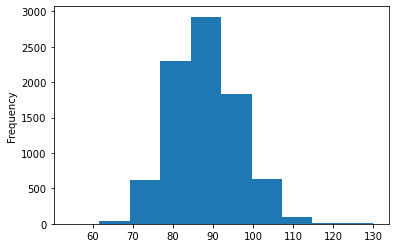

In [264]:
a.BP_Sys_mean.plot.hist()

<AxesSubplot:ylabel='Frequency'>

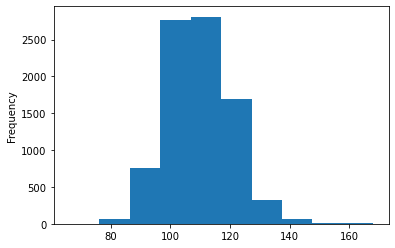

In [265]:
a.BP_Sys_max.plot.hist()

In [266]:
a.BP_Sys_mean.describe()

count    8487.000000
mean       87.809532
std         8.320585
min        54.000000
25%        81.000000
50%        87.000000
75%        93.500000
max       130.000000
Name: BP_Sys_mean, dtype: float64

In [267]:
a.BP_Sys_max.describe()

count    8487.000000
mean      108.841287
std        10.623366
min        66.000000
25%       100.000000
50%       110.000000
75%       116.000000
max       168.000000
Name: BP_Sys_max, dtype: float64

In [268]:
a.BP_Dia_mean.describe()

count    8487.000000
mean       66.754860
std         8.121806
min        30.000000
25%        60.000000
50%        66.000000
75%        72.000000
max       101.000000
Name: BP_Dia_mean, dtype: float64

In [269]:
a.BP_Sys_std.describe()

count    8487.000000
mean       29.743392
std         6.450909
min         0.000000
25%        25.455844
50%        29.698485
75%        33.941125
max        73.539105
Name: BP_Sys_std, dtype: float64

In [270]:
# new feature set with engineered features
ef = a.columns[nc:]
ef

Index(['Height_mean', 'Waist_mean', 'Waist_iliac_mean', 'Hip_mean',
       'BP_Sys_mean', 'BP_Dia_mean', 'Neck_mean', 'Height_std', 'Waist_std',
       'Waist_iliac_std', 'Hip_std', 'BP_Sys_std', 'BP_Dia_std', 'Neck_std',
       'Height_max', 'Waist_max', 'Waist_iliac_max', 'Hip_max', 'BP_Sys_max',
       'BP_Dia_max', 'Neck_max'],
      dtype='object')

In [271]:
fd['eng'] = ef
fs = fs + ['eng']

In [300]:
eflab = pd.DataFrame({'feature':ef,'dataset':'v1b','label':ef}).set_index('feature')
eflab

dataset             label
feature                                   
Height_mean          v1b       Height_mean
Waist_mean           v1b        Waist_mean
Waist_iliac_mean     v1b  Waist_iliac_mean
Hip_mean             v1b          Hip_mean
BP_Sys_mean          v1b       BP_Sys_mean
...                  ...               ...
Waist_iliac_max      v1b   Waist_iliac_max
Hip_max              v1b           Hip_max
BP_Sys_max           v1b        BP_Sys_max
BP_Dia_max           v1b        BP_Dia_max
Neck_max             v1b          Neck_max

[21 rows x 2 columns]

In [301]:
clab = pd.concat([clab,eflab])
clab

dataset                                 label
PublicID            v1b                     Public nuMoM2b ID
A02_Complete        a02               (A02) Data entry status
A02_Status          a02               (A02) Validation status
A02Ver              a02                    (A02) Form version
A02DATE_INT         a02  (A02) Date form completed - Interval
...                 ...                                   ...
Waist_iliac_max     v1b                       Waist_iliac_max
Hip_max             v1b                               Hip_max
BP_Sys_max          v1b                            BP_Sys_max
BP_Dia_max          v1b                            BP_Dia_max
Neck_max            v1b                              Neck_max

[9486 rows x 2 columns]

In [272]:
a.V1AE2_04c_4.dtype

dtype('float64')

### Data Reduction

In [273]:
# drop columns with high percentage of missing values
print(a.shape)
pthresh = 0.2
a = a.dropna(axis=1, thresh=int(pthresh*len(a)))
print(a.shape)

(8658, 11749)
(8658, 4325)


In [274]:
# join one-hots
fd['food'] = list(a_food_onehot.columns)
fd['drug'] = list(a_drug_onehot.columns)
fs = fs + ['food','drug']

In [275]:
adrop = [c for c in a.columns if (c in fd['food']) or c.startswith('DrugName')]
print(a.shape, len(adrop))
a = a.drop(columns=adrop)
print(a.shape)
a = pd.concat([a, a_food_onehot, a_drug_onehot], axis=1)
print(a.shape)

(8658, 4325) 761
(8658, 3564)
(8658, 4848)


In [276]:
# drop the rows with onehot value of blood pressure drugs == 1 
bld_pressure_drug = ["Labetalol", "nifedipine", "amlodipine", "hydrochlorothiazide", 
                     "chlorthalidone", "enalapril", "lisinopril", "carvedilol", "Atenolol"]

In [277]:
# just to make sure we catch the drug1/drug2 cases in which either drug1 or drug2 is one of these drugs 
bld_pressure_cols = [] 
for bpd in bld_pressure_drug:
    for drug_colname in drug_union:
        if drug_colname.__contains__(bpd.upper()):
            bld_pressure_cols.append("DrugName_"+drug_colname)
print(bld_pressure_cols)

['DrugName_LABETALOL', 'DrugName_NIFEDIPINE', 'DrugName_AMLODIPINE', 'DrugName_HYDROCHLOROTHIAZIDE', 'DrugName_HYDROCHLOROTHIAZIDE/TRIAMTRENE', 'DrugName_LISINOPRIL', 'DrugName_CARVEDILOL', 'DrugName_ATENOLOL']


In [278]:
a["bpd_indicator"] = a[bld_pressure_cols].sum(axis=1)

In [279]:
a = a[a.bpd_indicator == 0]
a.shape

(8641, 4849)

In [280]:
# drop blood pressure drug columns as features since they are now all zero
fd['drug'] = [f for f in fd['drug'] if f not in bld_pressure_cols + ['bpd_indicator']]
len(fd['drug'])

543

### Feature Labels

In [281]:
flab = pd.DataFrame({'feature':fd['food'],'dataset':'food','label':fd['food']}).set_index('feature')
dlab = pd.DataFrame({'feature':fd['drug'],'dataset':'drug','label':fd['drug']}).set_index('feature')
clab = pd.concat([clab,flab,dlab])
clab

dataset                     label
feature                                                   
PublicID                     NaN         Public nuMoM2b ID
A02_Complete                 a02   (A02) Data entry status
A02_Complete_1               a02   (A02) Data entry status
A02_Status                   a02   (A02) Validation status
A02_Status_1                 a02   (A02) Validation status
...                          ...                       ...
DrugName_SUCCINYLCHOLINE    drug  DrugName_SUCCINYLCHOLINE
DrugName_CISATRACURIUM      drug    DrugName_CISATRACURIUM
DrugName_DORNASE ALFA       drug     DrugName_DORNASE ALFA
DrugName_NEOSTIGMINE        drug      DrugName_NEOSTIGMINE
DrugName_DRONABINOL         drug       DrugName_DRONABINOL

[12893 rows x 2 columns]

In [282]:
clab = clab.drop_duplicates()
clab

dataset                                 label
feature                                                               
PublicID                     NaN                     Public nuMoM2b ID
A02_Complete                 a02               (A02) Data entry status
A02_Status                   a02               (A02) Validation status
A02Ver                       a02                    (A02) Form version
A02DATE_INT                  a02  (A02) Date form completed - Interval
...                          ...                                   ...
DrugName_SUCCINYLCHOLINE    drug              DrugName_SUCCINYLCHOLINE
DrugName_CISATRACURIUM      drug                DrugName_CISATRACURIUM
DrugName_DORNASE ALFA       drug                 DrugName_DORNASE ALFA
DrugName_NEOSTIGMINE        drug                  DrugName_NEOSTIGMINE
DrugName_DRONABINOL         drug                   DrugName_DRONABINOL

[9894 rows x 2 columns]

In [283]:
clab = clab[~clab.index.duplicated(keep='first')]
clab

dataset                                 label
feature                                                               
PublicID                     NaN                     Public nuMoM2b ID
A02_Complete                 a02               (A02) Data entry status
A02_Status                   a02               (A02) Validation status
A02Ver                       a02                    (A02) Form version
A02DATE_INT                  a02  (A02) Date form completed - Interval
...                          ...                                   ...
DrugName_SUCCINYLCHOLINE    drug              DrugName_SUCCINYLCHOLINE
DrugName_CISATRACURIUM      drug                DrugName_CISATRACURIUM
DrugName_DORNASE ALFA       drug                 DrugName_DORNASE ALFA
DrugName_NEOSTIGMINE        drug                  DrugName_NEOSTIGMINE
DrugName_DRONABINOL         drug                   DrugName_DRONABINOL

[9163 rows x 2 columns]

### Join Imputed Features

In [284]:
# imputed features were cimputed previously using lightgbm
# see notebooks lgb2a.ipynb, lgb2b.ipynb, lgb2c.ipynb, lgb2d.ipynb, lgb2e.ipynb
for i in ['a','b','c','d','e']:
    nm = f'lgb2{i}'
    b = pd.read_csv(nm+'.csv')
    a = a.merge(b,how='left',on=['PublicID'])
    print(nm, b.shape, a.shape)
    fd[nm] = list(b.columns)[1:]
    fs = fs + [nm]
    # blab = pd.DataFrame({'feature':fd[nm],'dataset':nm,'label':fd[nm]}).set_index('feature')
    lens = 1 + len(nm) + len('_pred')
    blab = pd.DataFrame({'feature1':fd[nm],'feature':[f[:-lens] for f in fd[nm]]}).set_index('feature')
    blab = blab.join(clab).set_index('feature1')
    print(blab.head())
    clab = pd.concat([clab,blab])

lgb2a (9289, 65) (8641, 4913)
                   dataset  \
feature1                     
CLAA01a_lgb2a_pred     cla   
CLAA01b_lgb2a_pred     cla   
CLAA01c_lgb2a_pred     cla   
CLAA01d_lgb2a_pred     cla   
CLAA02_lgb2a_pred      cla   

                                                                                 label  
feature1                                                                                
CLAA01a_lgb2a_pred                        (CLA) Complete blood count - Hemoglobin g/dL  
CLAA01b_lgb2a_pred                           (CLA) Complete blood count - Hematocrit %  
CLAA01c_lgb2a_pred                            (CLA) Complete blood count - MCV fL/cell  
CLAA01d_lgb2a_pred  (CLA) Complete blood count - Platelet count x10 3 /mm 3 (x10^3/µL)  
CLAA02_lgb2a_pred                         (CLA) Hemoglobin electrophoresis test result  
lgb2b (9289, 115) (8641, 5027)
                  dataset  \
feature1                    
V1AF02_lgb2b_pred     v1a   
V1AF04_lgb2b_pred 

In [285]:
clab['dataset'] = clab['dataset'].fillna('v1b')
clab['label'] = clab['label'].fillna(clab.index.to_series())
clab

dataset  \
PublicID                 v1b   
A02_Complete             a02   
A02_Status               a02   
A02Ver                   a02   
A02DATE_INT              a02   
...                      ...   
V2AF03_lgb2e_pred        v2a   
V2AF12_YR_lgb2e_pred     v2a   
V2AF13_lgb2e_pred        v2a   
V2AF15_lgb2e_pred        v2a   
V2AF20_lgb2e_pred        v2a   

                                                                                                             label  
PublicID                                                                                         Public nuMoM2b ID  
A02_Complete                                                                               (A02) Data entry status  
A02_Status                                                                                 (A02) Validation status  
A02Ver                                                                                          (A02) Form version  
A02DATE_INT                                                                   (A02) Date form completed - Interval  
...                                                                                                            ...  
V2AF03_lgb2e_pred                                                       (V2A) What is your current marital status?  
V2AF12_YR_lgb2e_pred  (V2A) How long did you know the biological father of the baby before this pregnancy? - Years  
V2AF13_lgb2e_pred                                                 (V2A) How old is the father of the baby? - Years  
V2AF15_lgb2e_pred                          (V2A) How many years of education has the father of the baby completed?  
V2AF20_lgb2e_pred              (V2A) How many years has the father of the baby lived in the United States? - Years  

[9465 rows x 2 columns]

In [289]:
clab.label

PublicID                                                                                           Public nuMoM2b ID
A02_Complete                                                                                 (A02) Data entry status
A02_Status                                                                                   (A02) Validation status
A02Ver                                                                                            (A02) Form version
A02DATE_INT                                                                     (A02) Date form completed - Interval
                                                                    ...                                             
V2AF03_lgb2e_pred                                                         (V2A) What is your current marital status?
V2AF12_YR_lgb2e_pred    (V2A) How long did you know the biological father of the baby before this pregnancy? - Years
V2AF13_lgb2e_pred                                               

In [290]:
clab[['BP' in f for f in clab.label]]

dataset  \
CMAA01k2c                  cma   
CMAA02k2c                  cma   
CMBA01j2c                  cmb   
BP_Sys_mean_lgb2d_pred     v1b   
BP_Dia_mean_lgb2d_pred     v1b   
BP_Sys_std_lgb2d_pred      v1b   
BP_Sys_max_lgb2d_pred      v1b   
BP_Dia_max_lgb2d_pred      v1b   

                                                                                                                      label  
CMAA01k2c               (CMA) Provider's Reasons for Admission to L & D - Abnormal fetal testing - Abnormal biophysical ...  
CMAA02k2c               (CMA) Providers PRIMARY reason for delivery - Abnormal fetal testing - Abnormal biophysical prof...  
CMBA01j2c               (CMB) Provider's reason for admission, encounter, or procedure - Abnormal biophysical profile (B...  
BP_Sys_mean_lgb2d_pred                                                                               BP_Sys_mean_lgb2d_pred  
BP_Dia_mean_lgb2d_pred                                                                               BP_Dia_mean_lgb2d_pred  
BP_Sys_std_lgb2d_pred                                                                                 BP_Sys_std_lgb2d_pred  
BP_Sys_max_lgb2d_pred                                                                                 BP_Sys_max_lgb2d_pred  
BP_Dia_max_lgb2d_pred                                                                                 BP_Dia_max_lgb2d_pred

In [86]:
fs

['cla',
 'demographics',
 's01',
 's02',
 'u02',
 'u1c',
 'v1a',
 'v1b',
 'v1c',
 'v1e',
 'v1f',
 'v1g',
 'v1h',
 'v1k',
 'v1l',
 'v2a',
 'v2b',
 'v2i',
 'v2m',
 'eng',
 'food',
 'drug',
 'lgb2a',
 'lgb2b',
 'lgb2c',
 'lgb2d',
 'lgb2e']

### Assemble Final Features

In [88]:
# assemble features
features = []
for s in fs: features.extend(fd[s])
# restrict to numeric features, remove _INT dates
features = [f for f in features if ((f in a.columns) and (a[f].dtype != 'O') and (f[-4:]!='_INT')) and \
           (f not in drop)]

# drop other features
features = [f for f in features if f[:4] not in ['CLAC','CLAD']]

features[:10], features[-10:], len(features)

(['CLAVer',
  'CLAA01a',
  'CLAA01b',
  'CLAA01c',
  'CLAA01d',
  'CLAA02',
  'CLAA03',
  'CLAA04',
  'CLAA05',
  'CLAA06'],
 ['V2AE04a1a_lgb2e_pred',
  'V2AE04a1b_lgb2e_pred',
  'V2AE07_1a_lgb2e_pred',
  'V2AE07_1b1_lgb2e_pred',
  'V2AE09a_1a_lgb2e_pred',
  'V2AF03_lgb2e_pred',
  'V2AF12_YR_lgb2e_pred',
  'V2AF13_lgb2e_pred',
  'V2AF15_lgb2e_pred',
  'V2AF20_lgb2e_pred'],
 2233)

In [90]:
# save preprocessed data as a csv
cols = ['PublicID','tte','censor','tte2',target] + features
fname = mname + '.csv'
a[cols].to_csv(fname, index=False)
print(fname, a[cols].shape)

xgb1t.csv (8641, 2238)


# XGBoost Training

In [91]:
# features and target
x = a[features]
y = a[target]
print(x.shape, y.shape)

(8641, 2233) (8641,)


In [92]:
np.mean(x)

CLAVer                    3.932714
CLAA01a                  12.917381
CLAA01b                  38.059475
CLAA01c                  89.535003
CLAA01d                 252.891961
                           ...    
V2AF03_lgb2e_pred         1.645564
V2AF12_YR_lgb2e_pred      6.071050
V2AF13_lgb2e_pred        29.226280
V2AF15_lgb2e_pred         4.872787
V2AF20_lgb2e_pred        26.597353
Length: 2233, dtype: float64

In [93]:
np.mean(y)

-152.74293372037698

In [97]:
# create directories to save results
os.makedirs(path+'mod', exist_ok=True)
os.makedirs(path+'oof', exist_ok=True)
os.makedirs(path+'imp', exist_ok=True)
os.makedirs(path+'sub', exist_ok=True)
os.makedirs(path+'cvr', exist_ok=True)

In [98]:
# !pip install xgboost --upgrade

In [99]:
import xgboost as xgb
from sklearn.model_selection import KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error

In [100]:
y.describe()

count    8641.000000
mean     -152.742934
std       222.114220
min      -304.000000
25%      -282.000000
50%      -274.000000
75%      -219.000000
max       316.055556
Name: tthd, dtype: float64

In [101]:
# Harrell's C concordance index, AUC for survival, sorting efficiency
# https://github.com/jameslu01/Compute_HazRatio_ML/blob/main/XGB_Code_Data/Breast%20Cancer/BreastCancer_Dataset_HR_Estimations_Manuscript_Mean.ipynb
def c_statistic_harrell(labels, pred):
    if isinstance(labels, pd.Series): labels = labels.values
    total = 0
    matches = 0
    for i in range(len(labels)):
        for j in range(len(labels)):
            if int(labels[j]) > 0 and abs(int(labels[i])) > int(labels[j]):
                total += 1
                if pred[j] > pred[i]:
                    matches += 1
    return matches/total

In [102]:
from sklearn.metrics import make_scorer
c_scorer = make_scorer(c_statistic_harrell)

<AxesSubplot:ylabel='Frequency'>

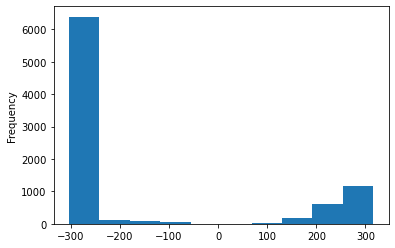

In [103]:
y.plot.hist()

### Set Up for Randomized Search Cross Validation

In [104]:
N_SPLITS = 5
N_REPEATS = 10
N_TRIES = 10
seed = 930
folds = []
for i in range(N_REPEATS):
    folds.extend(list(StratifiedKFold(n_splits=N_SPLITS, random_state=i+seed, shuffle=True).split(x, (y > 0))))
print(len(folds))

50


In [105]:
# xgboost hyperparameter ranges for RandomizedSearchCV
params = {
    'max_depth': [1, 2, 3, 4, 5],
    'n_estimators': [ 50, 100, 150, 225, 350 ],  
    # 'min_split_gain': [0, 0, 1e-4, 1e-3, 1e-2, 0.1],
    # 'min_child_samples': [ 1, 2, 4, 7, 10, 20, 30, 40, 70, 100],
    'min_child_weight': [0, 1, 3, 5, 7],
    # 'num_leaves': [20, 30, 50, 100],
    # 'num_parallel_tree': [1, 3, 5, 7],
    'num_parallel_tree': [5],
    'learning_rate': [0.03, 0.05, 0.07, 0.1],         
    'colsample_bytree': [0.33, 0.5, 0.65, 0.8, 0.9, 1.0], 
    'colsample_bynode':[0.33, 0.5, 0.65, 0.81, 0.9, 1.0],
    'reg_lambda': [0, 1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 10, 100],
    'reg_alpha': [0, 1e-3, 1e-2, 0.1, 1, 10], 
    'subsample': [0.6, 0.7, 0.8, 0.9, 1],
    # 'subsample_freq': [1],
    'max_bin': [50, 90, 125, 175, 255],
    # 'tree_method': ['gpu_hist']
    # 'booster': ['gblinear']
    # 'booster': ['dart'] 
    # 'grow_policy': ['depthwise', 'lossguide']
    # 'linear_tree': [True]
#     'aft_loss_distribution': ['normal','logistic','extreme'],
#     'aft_loss_distribution_scale': [0.5, 1.0, 1.5]
}    


In [106]:
# set up for modeling
model = xgb.XGBRegressor(objective='survival:cox',importance_type=importance_type)
n_iter = N_TRIES
scoring = c_scorer
# cv = StratifiedKFold(n_splits = N_SPLITS, shuffle = True)
cv = KFold(n_splits = N_SPLITS, shuffle = True)
verbose = 5

importance_type = 'gain'
# importance_type = 'weight'
# importance_type = 'cover

### Main Training Loop

In [107]:
# main cross validation loop, takes several hours

scores = []; y_preds = []; test_preds = []; models = []; cv_results = []
start = time.time()

for fold_idx, fold in enumerate(folds[:N_REPEATS * N_SPLITS]):

    foldi = fold_idx // N_SPLITS
    foldj = fold_idx % N_SPLITS

    print()
    print("Fold", foldi, foldj)

    clf = RandomizedSearchCV(model, params, n_iter = n_iter,
        scoring = scoring, n_jobs = -1,
        cv = cv
    )

    xr = x.iloc[fold[0]].copy()
    yr = y.iloc[fold[0]].copy()
    print(xr.shape, yr.shape)
    
    clf.fit(xr, yr)

    model = clf.best_estimator_
    models.append(model)

    if verbose >= 3:
        print(model)

    cvr = pd.DataFrame(clf.cv_results_)
    cvr['fold_idx'] = fold_idx
    cv_results.append(cvr)

    y_pred = ( (model.predict_proba if hasattr(model, 'predict_proba') else model.predict)
        (x.iloc[fold[1]]) )

    y_pred = y_pred[:, -1] if len(y_pred.shape) == 2 else y_pred

    print(len(y_pred), y_pred.min(), y_pred.max())
   
    yv = y.iloc[fold[1]].values
    score = scoring._score_func(yv, y_pred)
    print(f'score {score:.4f}')
    scores.append( score )

    y_preds.append( pd.DataFrame(y_pred, index = x.iloc[fold[1]].index ) )
    # break

    if (fold_idx + 1) % N_SPLITS == 0:
        print('Running average after {} repeats: {:.4f}'.format( fold_idx // N_SPLITS + 1, np.mean(scores)) )
        yp = pd.concat(y_preds)
        yp = yp.groupby(yp.index).mean()
        if (len(yp) == len(y)):
            print('Blended average after {} repeats: {:.4f}'.format( fold_idx // N_SPLITS + 1,
                scoring._score_func(y.values, yp.values )  ))
        print('{:.1f}s'.format(time.time() - start))
        print()

# save oofs
yp = pd.concat(y_preds)
fname = f'oof/{mname}.pkl'
yp.to_pickle(fname)
print(fname, yp.shape)

#     # save test set predictions
#     test_preds_all = np.stack(test_preds)
#     fname = f'sub/{mname}.npy'
#     np.save(fname, test_preds_all)
#     print(fname, test_preds_all.shape)
test_preds = None

cvraf = pd.concat(cv_results)
fname = f'cvr/{mname}.csv'
cvraf.to_csv(fname, index=False)
print(cvraf)
print(fname, cvraf.shape)


Fold 0 0
(6912, 2233) (6912,)
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=0.65, colsample_bytree=0.9, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.03, max_bin=125, max_delta_step=0, max_depth=4,
             min_child_weight=7, missing=nan, monotone_constraints='()',
             n_estimators=350, n_jobs=14, num_parallel_tree=5,
             objective='survival:cox', random_state=0, reg_alpha=0.01,
             reg_lambda=0.01, scale_pos_weight=None, subsample=0.6,
             tree_method='exact', validate_parameters=1, verbosity=None)
1729 0.11571778 7.400366
score 0.6899

Fold 0 1
(6913, 2233) (6913,)
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=0.33, colsample_bytree=0.8, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.07, max_bin=90, max_delt

In [198]:
# save models for later deployment
import pickle
fname = mname + '_models.pkl'
pickle.dump(models, open(fname, 'wb'))
print(fname)

xgb1t_models.pkl


In [199]:
models = pickle.load(open(fname, 'rb'))
len(models)

50

# Prediction Results

In [113]:
# out-of-fold predictions
yp = pd.concat(y_preds)
yp = yp.groupby(yp.index).mean()
yp.describe()

0
count  8641.000000
mean      0.600392
std       0.475345
min       0.141227
25%       0.330101
50%       0.455906
75%       0.686952
max       6.836109

In [200]:
# ground truth values, note censored values are negative (xgboost convention)
y.describe()

count    8641.000000
mean     -152.742934
std       222.114220
min      -304.000000
25%      -282.000000
50%      -274.000000
75%      -219.000000
max       316.055556
Name: tthd, dtype: float64

In [201]:
# overall c-index score of out-of-fold predictions
scoring._score_func(y.values, yp.values)

0.6972314401453793

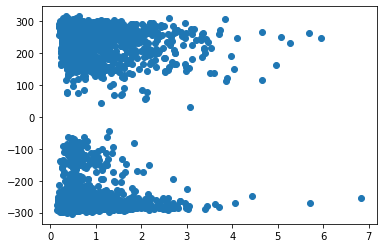

In [117]:
# plot actional by predicted 
plt.scatter(x=yp,y=y)

<AxesSubplot:ylabel='Frequency'>

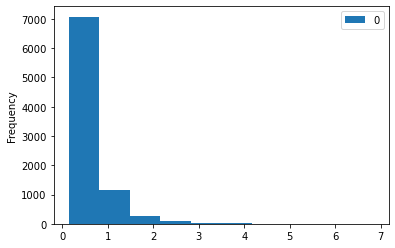

In [118]:
yp.clip(0,10).plot.hist()

In [123]:
# compare predictions with binary target
hmap0 = {1:1,2:1,3:1,4:1,5:1,6:1,7:0,np.nan:0}
a['hmap0'] = a.PEgHTN.map(hmap0)
a.hmap0.value_counts()

0    6655
1    1986
Name: hmap0, dtype: int64

<AxesSubplot:ylabel='Frequency'>

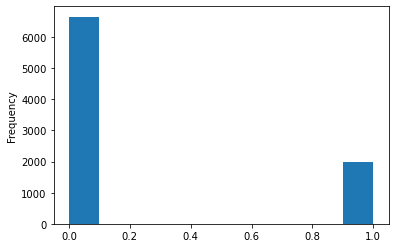

In [124]:
yb = a.hmap0
yb.plot.hist()

In [128]:
np.sqrt(mean_squared_error(yp, yb))

0.653096966222224

<AxesSubplot:xlabel='0', ylabel='hmap0'>

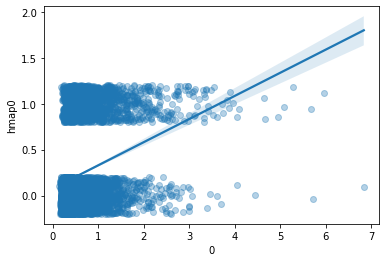

In [130]:
sb.regplot(x = yp, y = yb, fit_reg = True,
           x_jitter = 0.0, y_jitter = 0.2, scatter_kws = {'alpha' : 1/3})

In [132]:
np.corrcoef(yp.values.flatten(), yb.values)

array([[1.        , 0.28431626],
       [0.28431626, 1.        ]])

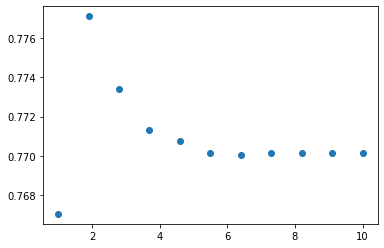

In [133]:
from sklearn.metrics import accuracy_score, roc_curve, auc
cuts = np.linspace(1,10,num=11)
acc = [accuracy_score(yp > c,yb) for c in cuts]
plt.scatter(x=cuts, y=acc)

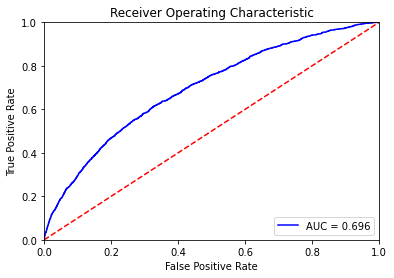

In [134]:
fpr, tpr, threshold = roc_curve(yb, yp)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Feature Importance

In [135]:
# compute average feature importance over all models
for m in models: m.importance_type = importance_type

In [302]:
imp = [pd.DataFrame({'feature':features,importance_type:m.feature_importances_}) for m in models]
imp = pd.concat(imp).groupby('feature').mean()
imp.sort_values(importance_type, inplace=True, ascending=False)

In [303]:
# join feature labels
imp = imp.join(clab)

In [304]:
# top 10 most important features
imp[:10]

gain       dataset  \
feature                                               
V2BA02a1_lgb2d_pred          0.007604           v2b   
V2BA02b1_lgb2d_pred          0.007056           v2b   
Waist_iliac_mean_lgb2d_pred  0.005637           v1b   
Waist_iliac_max_lgb2d_pred   0.004422           v1b   
BP_Sys_mean_lgb2d_pred       0.004136           v1b   
BP_Sys_max_lgb2d_pred        0.004074           v1b   
BMI_lgb2a_pred               0.003992  demographics   
V2BA02a1                     0.003815           v2b   
BP_Sys_mean                  0.003648           v1b   
V1BA01_LB                    0.003604           v1b   

                                                                                            label  
feature                                                                                            
V2BA02a1_lgb2d_pred                      (V2B) Resting blood pressure - Systolic measure 1 (mmHg)  
V2BA02b1_lgb2d_pred                     (V2B) Resting blood pressure - Diastolic measure 1 (mmHg)  
Waist_iliac_mean_lgb2d_pred                                           Waist_iliac_mean_lgb2d_pred  
Waist_iliac_max_lgb2d_pred                                             Waist_iliac_max_lgb2d_pred  
BP_Sys_mean_lgb2d_pred                                                     BP_Sys_mean_lgb2d_pred  
BP_Sys_max_lgb2d_pred                                                       BP_Sys_max_lgb2d_pred  
BMI_lgb2a_pred               BMI (kg/m^2) at visit 1 calculated from height and weight (form V1B)  
V2BA02a1                                 (V2B) Resting blood pressure - Systolic measure 1 (mmHg)  
BP_Sys_mean                                                                           BP_Sys_mean  
V1BA01_LB                                                                      (V1B) Weight - lbs

In [305]:
# next 10, features 11-20
imp[10:20]

gain dataset  \
feature                                   
V2BA01_LB_lgb2d_pred   0.003551     v2b   
Waist_mean_lgb2d_pred  0.003511     v1b   
Waist_iliac_mean       0.003416     v1b   
V1BA01_LB_lgb2b_pred   0.003322     v1b   
Waist_iliac_max        0.003157     v1b   
DrugName_INSULIN       0.003028    drug   
V1LE01b_lgb2c_pred     0.002985     v1l   
V1EA02a_lgb2b_pred     0.002966     v1e   
Waist_max_lgb2d_pred   0.002938     v1b   
CLAA01d_lgb2a_pred     0.002797     cla   

                                                                                                                     label  
feature                                                                                                                     
V2BA01_LB_lgb2d_pred                                                                                    (V2B) Weight - lbs  
Waist_mean_lgb2d_pred                                                                                Waist_mean_lgb2d_pred  
Waist_iliac_mean                                                                                          Waist_iliac_mean  
V1BA01_LB_lgb2b_pred                                                                                    (V1B) Weight - lbs  
Waist_iliac_max                                                                                            Waist_iliac_max  
DrugName_INSULIN                                                                                          DrugName_INSULIN  
V1LE01b_lgb2c_pred                                               (V1L) How often did you snore before you became pregnant?  
V1EA02a_lgb2b_pred     (V1E) Are you feeling bothered, upset or worried at this point in your pregnancy - About the eff...  
Waist_max_lgb2d_pred                                                                                  Waist_max_lgb2d_pred  
CLAA01d_lgb2a_pred                                      (CLA) Complete blood count - Platelet count x10 3 /mm 3 (x10^3/µL)

In [306]:
# next 10, features 21-30
imp[20:30]

gain       dataset  \
feature                                        
Neck_max_lgb2d_pred   0.002750           v1b   
BMI                   0.002686  demographics   
Neck_mean_lgb2d_pred  0.002683           v1b   
BP_Sys_max            0.002617           v1b   
Neck_mean             0.002567           v1b   
Waist_mean            0.002562           v1b   
U02B03                0.002546           u02   
Neck_max              0.002423           v1b   
S02E03                0.002413           s02   
U02B04a               0.002384           u02   

                                                                                                      label  
feature                                                                                                      
Neck_max_lgb2d_pred                                                                     Neck_max_lgb2d_pred  
BMI                                    BMI (kg/m^2) at visit 1 calculated from height and weight (form V1B)  
Neck_mean_lgb2d_pred                                                                   Neck_mean_lgb2d_pred  
BP_Sys_max                                                                                       BP_Sys_max  
Neck_mean                                                                                         Neck_mean  
Waist_mean                                                                                       Waist_mean  
U02B03                                                                   (U02) Crown rump length (CRL) - mm  
Neck_max                                                                                           Neck_max  
S02E03                                                                (S02) Clinical or research ultrasound  
U02B04a               (U2A) Gestational age by project estimated date of delivery (EDD) on U/S date - Weeks

In [307]:
# next 10, features 31-40
imp[30:40]

gain                  dataset  \
feature                                                     
V1AD01b_lgb2a_pred      0.002149                      v1a   
CLAE02a1                0.002135                      cla   
CLAB02d2                0.002114                      cla   
CLAE08                  0.002029                      cla   
V2BA02b1                0.002022                      v2b   
V2BA01_LB               0.002021                      v2b   
BP_Dia_mean_lgb2d_pred  0.001988                      v1b   
S01A07                  0.001973                      s01   
SOFTDRINKSFREQ          0.001951  food_frequency_analysis   
V2AE01a_LB_lgb2c_pred   0.001946                      v2a   

                                                                                                                      label  
feature                                                                                                                      
V1AD01b_lgb2a_pred                                              (V1A) How much did you weigh before you got pregnant? - lbs  
CLAE02a1                                                            (CLA) Glucose screen (50g challenge) - Result mg/dL (a)  
CLAB02d2                                  (CLA) First trimester serum screen PAPP-A Results - Multiples of the median (MoM)  
CLAE08                  (CLA) First formal proteinuria quantification (if done prior to 20/0 weeks project estimated ges...  
V2BA02b1                                                          (V2B) Resting blood pressure - Diastolic measure 1 (mmHg)  
V2BA01_LB                                                                                                (V2B) Weight - lbs  
BP_Dia_mean_lgb2d_pred                                                                               BP_Dia_mean_lgb2d_pred  
S01A07                                      (S01) Exclusion criteria - Likely lethal fetal malformation or fetal aneuploidy  
SOFTDRINKSFREQ                                Any kind of soft drink, cola, Sprite, orange soda, regular or diet, frequency  
V2AE01a_LB_lgb2c_pred                                             (V2A) How much did you weigh when you were born? - Pounds

In [308]:
# aggregate importances by group
ig = imp.groupby('dataset').mean().sort_values(importance_type, ascending=False)
ig['prop'] = ig[importance_type]/ig[importance_type].sum()
ig[:10]

gain      prop
dataset                         
v2b           0.003266  0.203698
v1b           0.001973  0.123066
u02           0.001380  0.086078
cla           0.001025  0.063951
demographics  0.000835  0.052081
v1g           0.000822  0.051281
v1l           0.000757  0.047236
v1e           0.000742  0.046254
v1k           0.000674  0.042034
v1c           0.000656  0.040902

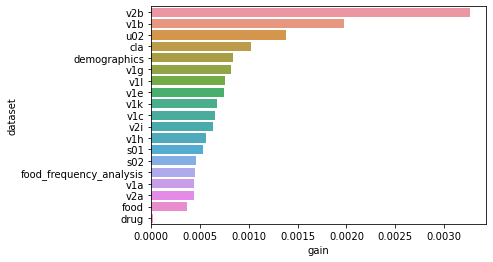

In [309]:
# greoup importance bar chart
# bp = sb.barplot(x=ig.index, y=ig.gain)
bp = sb.barplot(y=ig.index, x=ig[importance_type], orient='h')
# plt.xticks(rotation=-45)
plt.show()

### Shapley Plots

In [310]:
# !pip install shap --upgrade

In [326]:
# get more informative feature names / labels
feature_names = [clab[clab.index==f]['label'].values[0] if f in clab.index else f for f in features]
# truncate overly long ones
feature_names = [f[:50] for f in feature_names]
print(feature_names[:10],feature_names[-10:])

['(CLA) Form version', '(CLA) Complete blood count - Hemoglobin g/dL', '(CLA) Complete blood count - Hematocrit %', '(CLA) Complete blood count - MCV fL/cell', '(CLA) Complete blood count - Platelet count x10 3 ', '(CLA) Hemoglobin electrophoresis test result', '(CLA) Blood type', '(CLA) Rh factor', '(CLA) Antibody screen', '(CLA) Urine culture'] ['(V2A) Family member diagnosed with diabetes - Fami', '(V2A) Family member diagnosed with diabetes - Diab', '(V2A) Family members with pregnancy complications ', '(V2A) Family members with pregnancy complications ', '(V2A) Family members with hypertension - Family re', '(V2A) What is your current marital status?', '(V2A) How long did you know the biological father ', '(V2A) How old is the father of the baby? - Years', '(V2A) How many years of education has the father o', '(V2A) How many years has the father of the baby li']


In [327]:
len(feature_names)

2233

In [329]:
import shap
# average out-of-fold shap values over folds
e = []; v = []; b = []; d = []
for fold_idx, fold in enumerate(folds[:N_REPEATS * N_SPLITS]):
    if fold_idx % 10 == 0: print(fold_idx)
    explainer = shap.Explainer(models[fold_idx], feature_names=feature_names)
    xv = x.iloc[fold[1]]
    s = explainer(xv)
    e.append(s)
    v.append(pd.DataFrame(s.values, index=xv.index))
    b.append(pd.Series(s.base_values, index=xv.index))
    d.append(pd.DataFrame(s.data, index=xv.index))

0
10
20
30
40


In [330]:
va = pd.concat(v)
va = va.groupby(va.index).mean()
va

0         1         2         3         4         5         6     \
0     0.000068  0.002069 -0.000035  0.001205 -0.020581  0.002732 -0.000221   
1     0.000173  0.000736  0.000366  0.000432 -0.014793  0.004066 -0.000950   
2     0.000067 -0.001481  0.002735  0.001420  0.032969  0.004762  0.002168   
3     0.000025  0.000699 -0.000385  0.001367 -0.025566  0.005841 -0.000790   
4     0.000189 -0.001826  0.000685  0.001211 -0.022673 -0.011808  0.009939   
...        ...       ...       ...       ...       ...       ...       ...   
8636  0.000047 -0.002895 -0.001888  0.000304 -0.024469  0.003355  0.002240   
8637  0.000264  0.001090  0.001566  0.000595 -0.023323  0.004638 -0.000254   
8638  0.000044  0.001621 -0.001932  0.000237 -0.034307 -0.013317 -0.001438   
8639 -0.001054 -0.006169  0.001532 -0.000089 -0.023275 -0.009599 -0.000523   
8640  0.000207  0.001218 -0.000242 -0.000336  0.026920  0.002881 -0.000909   

              7         8         9     ...      2223      2224      2225  \
0     0.000000e+00  0.000234 -0.000075  ... -0.001313 -0.000219 -0.020427   
1    -5.957559e-06  0.000093 -0.001228  ...  0.005213  0.000874  0.073576   
2     4.282254e-07  0.000134  0.000266  ...  0.000352 -0.000548 -0.025567   
3     0.000000e+00  0.000178  0.000121  ...  0.001192  0.000117 -0.020458   
4     5.698214e-06  0.000370  0.000612  ...  0.000701 -0.000609  0.026227   
...            ...       ...       ...  ...       ...       ...       ...   
8636  0.000000e+00  0.000267 -0.000963  ...  0.000393 -0.000320 -0.021793   
8637 -4.231441e-06  0.000362  0.000738  ... -0.000419 -0.000461  0.050574   
8638  3.336984e-06  0.000077  0.000587  ...  0.000359  0.000312  0.009740   
8639  8.513984e-05  0.000037  0.000162  ... -0.001662  0.000376 -0.023088   
8640  2.486342e-05  0.000042  0.000167  ...  0.000224 -0.000266 -0.018635   

          2226      2227      2228      2229      2230      2231      2232  
0     0.018962  0.001636 -0.002191  0.000165 -0.000389 -0.000835 -0.002144  
1     0.018743 -0.001024 -0.001062  0.001541  0.000418 -0.000229  0.001443  
2     0.021984  0.002436 -0.003170 -0.000104 -0.000777 -0.000168  0.001470  
3    -0.005034 -0.000660 -0.003287  0.000298 -0.001432 -0.000910  0.000851  
4     0.020831 -0.002241  0.009778 -0.000472 -0.000548  0.004962  0.000428  
...        ...       ...       ...       ...       ...       ...       ...  
8636  0.005759  0.001018 -0.002582  0.000035  0.000775 -0.001114 -0.000928  
8637  0.021990 -0.002372 -0.000459 -0.000181 -0.000736  0.000031  0.002225  
8638 -0.004706 -0.000903 -0.002365  0.001121 -0.000052 -0.001800 -0.003080  
8639 -0.003401 -0.000431 -0.002017  0.001008 -0.001030 -0.001298  0.000185  
8640 -0.006885  0.004134 -0.000802 -0.000445  0.003442  0.003339 -0.002468  

[8641 rows x 2233 columns]

In [331]:
ba = pd.concat(b)
ba = ba.groupby(ba.index).mean()
ba

0      -0.695011
1      -0.702422
2      -0.728932
3      -0.702007
4      -0.735708
          ...   
8636   -0.700870
8637   -0.723733
8638   -0.729011
8639   -0.708506
8640   -0.760137
Length: 8641, dtype: float32

In [332]:
da = pd.concat(d)
da = da.groupby(da.index).mean()
da.columns = features
da

CLAVer  CLAA01a  CLAA01b  CLAA01c  CLAA01d  CLAA02  CLAA03  CLAA04  \
0        4.0     12.9     36.8     84.0    213.0     NaN     2.0     1.0   
1        4.0     12.7     36.3     89.3    236.0     NaN     3.0     1.0   
2        4.0     14.7     43.3     91.9    281.0     NaN     1.0     1.0   
3        4.0     11.6     33.7      NaN    200.0     NaN     3.0     1.0   
4        4.0     11.1     33.5     81.0    224.0     1.0     4.0     1.0   
...      ...      ...      ...      ...      ...     ...     ...     ...   
8636     4.0     11.1     33.0     80.5    207.0     NaN     1.0     1.0   
8637     4.0     14.0     39.9     90.0    215.0     NaN     2.0     1.0   
8638     4.0     12.3     37.0     90.7    172.0     1.0     3.0     1.0   
8639     3.0     14.9     43.8     91.7    202.0     1.0     3.0     2.0   
8640     4.0     12.8     38.2     90.7    292.0     NaN     3.0     1.0   

      CLAA05  CLAA06  ...  V2AE04a1a_lgb2e_pred  V2AE04a1b_lgb2e_pred  \
0        2.0     2.0  ...              1.993919              2.015395   
1        2.0     3.0  ...              1.449359              2.460920   
2        2.0     2.0  ...              1.804453              1.903546   
3        2.0     NaN  ...              1.625783              2.154715   
4        2.0     2.0  ...              1.754238              1.907252   
...      ...     ...  ...                   ...                   ...   
8636     2.0     3.0  ...              1.909722              1.915677   
8637     2.0     2.0  ...              1.807342              1.933058   
8638     2.0     2.0  ...              1.787936              1.982174   
8639     2.0     2.0  ...              1.969813              1.886398   
8640     2.0     NaN  ...              1.739252              1.881910   

      V2AE07_1a_lgb2e_pred  V2AE07_1b1_lgb2e_pred  V2AE09a_1a_lgb2e_pred  \
0                 1.924020               1.285101               1.600745   
1                 1.198466               1.150963               1.289599   
2                 1.985898               0.937406               1.593668   
3                 1.825281               6.331004               1.250983   
4                 1.585172               1.146009               1.377700   
...                    ...                    ...                    ...   
8636              1.811723               2.270842               1.623848   
8637              1.483246               1.226489               1.486319   
8638              1.700994               6.256494               1.470966   
8639              1.884832               6.415991               1.472719   
8640              1.780323               6.151043               1.542713   

      V2AF03_lgb2e_pred  V2AF12_YR_lgb2e_pred  V2AF13_lgb2e_pred  \
0              1.991739              4.151848          26.304735   
1              1.146128              3.934600          38.670366   
2              2.603945              6.218955          31.940812   
3              1.996202              8.525869          33.039455   
4              1.011201              3.931526          28.347462   
...                 ...                   ...                ...   
8636           2.011811              4.228499          25.348786   
8637           1.163198              4.895020          37.411601   
8638           2.034816              8.444979          39.686144   
8639           1.991489              7.930590          31.726282   
8640           1.101953              3.297882          20.279586   

      V2AF15_lgb2e_pred  V2AF20_lgb2e_pred  
0              4.549716          21.434899  
1              3.522186          35.867546  
2              4.107502          31.164645  
3              6.614449          31.647384  
4              2.746613          27.932554  
...                 ...                ...  
8636           4.681557          23.931116  
8637           3.626896          34.530967  
8638           6.166852          20.700589  
8639           6.935094          27.

In [333]:
# should be same as da 
x

CLAVer  CLAA01a  CLAA01b  CLAA01c  CLAA01d  CLAA02  CLAA03  CLAA04  \
0        4.0     12.9     36.8     84.0    213.0     NaN     2.0     1.0   
1        4.0     12.7     36.3     89.3    236.0     NaN     3.0     1.0   
2        4.0     14.7     43.3     91.9    281.0     NaN     1.0     1.0   
3        4.0     11.6     33.7      NaN    200.0     NaN     3.0     1.0   
4        4.0     11.1     33.5     81.0    224.0     1.0     4.0     1.0   
...      ...      ...      ...      ...      ...     ...     ...     ...   
8636     4.0     11.1     33.0     80.5    207.0     NaN     1.0     1.0   
8637     4.0     14.0     39.9     90.0    215.0     NaN     2.0     1.0   
8638     4.0     12.3     37.0     90.7    172.0     1.0     3.0     1.0   
8639     3.0     14.9     43.8     91.7    202.0     1.0     3.0     2.0   
8640     4.0     12.8     38.2     90.7    292.0     NaN     3.0     1.0   

      CLAA05  CLAA06  ...  V2AE04a1a_lgb2e_pred  V2AE04a1b_lgb2e_pred  \
0        2.0     2.0  ...              1.993919              2.015395   
1        2.0     3.0  ...              1.449359              2.460920   
2        2.0     2.0  ...              1.804453              1.903546   
3        2.0     NaN  ...              1.625783              2.154715   
4        2.0     2.0  ...              1.754238              1.907252   
...      ...     ...  ...                   ...                   ...   
8636     2.0     3.0  ...              1.909722              1.915677   
8637     2.0     2.0  ...              1.807342              1.933058   
8638     2.0     2.0  ...              1.787936              1.982174   
8639     2.0     2.0  ...              1.969813              1.886398   
8640     2.0     NaN  ...              1.739252              1.881910   

      V2AE07_1a_lgb2e_pred  V2AE07_1b1_lgb2e_pred  V2AE09a_1a_lgb2e_pred  \
0                 1.924020               1.285101               1.600745   
1                 1.198466               1.150963               1.289599   
2                 1.985898               0.937406               1.593668   
3                 1.825281               6.331004               1.250983   
4                 1.585172               1.146009               1.377700   
...                    ...                    ...                    ...   
8636              1.811723               2.270842               1.623848   
8637              1.483246               1.226489               1.486319   
8638              1.700994               6.256494               1.470966   
8639              1.884832               6.415991               1.472719   
8640              1.780323               6.151043               1.542713   

      V2AF03_lgb2e_pred  V2AF12_YR_lgb2e_pred  V2AF13_lgb2e_pred  \
0              1.991739              4.151848          26.304735   
1              1.146128              3.934600          38.670366   
2              2.603945              6.218955          31.940812   
3              1.996202              8.525869          33.039455   
4              1.011201              3.931526          28.347462   
...                 ...                   ...                ...   
8636           2.011811              4.228499          25.348786   
8637           1.163198              4.895020          37.411601   
8638           2.034816              8.444979          39.686144   
8639           1.991489              7.930590          31.726282   
8640           1.101953              3.297882          20.279586   

      V2AF15_lgb2e_pred  V2AF20_lgb2e_pred  
0              4.549716          21.434899  
1              3.522186          35.867546  
2              4.107502          31.164645  
3              6.614449          31.647384  
4              2.746613          27.932554  
...                 ...                ...  
8636           4.681557          23.931116  
8637           3.626896          34.530967  
8638           6.166852          20.700589  
8639           6.935094          27.

In [334]:
# create single combined shap_values object
# override attributes of e[0] to use averaged values from above
shap_values = e[0]
shap_values.values = va.values
shap_values.base_values = ba.values
shap_values._s.values = va.values
shap_values._s.base_values = ba.values
shap_values._s.data = da.values
shap_values.feature_names = feature_names
shap_values.shape

(8641, 2233)

In [335]:
# save combined shap values
import pickle
fname = mname + '_shap.pkl'
pickle.dump(shap_values, open(fname, 'wb'))
print(fname)

xgb1t_shap.pkl


In [336]:
shap_values = pickle.load(open(fname, 'rb'))

In [337]:
# shap_values.__dict__

#### First example

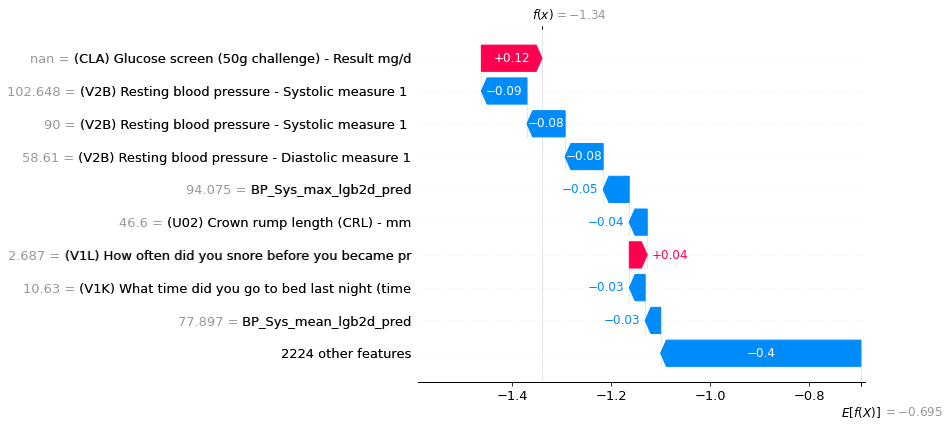

In [338]:
# example waterfall plot for first mom
# red arrow right indicates feature making her risk score worse
# blue arrow left indicates feature making her risk score better
shap.plots.waterfall(shap_values[0])
plt.show()

In [339]:
# set up for sorting
ypp = np.array([p[0] for p in yp.values])
ypp[:10]

array([0.26506945, 0.65392387, 0.44994685, 0.31143203, 0.6344285 ,
       0.40531522, 0.37472916, 0.5285164 , 0.23230669, 0.6495306 ],
      dtype=float32)

In [340]:
# sort index for risk scores
isort = np.argsort(-ypp)
isort

array([6096, 1077, 3861, ...,  293, 4930, 7015])

####  Ten worst risk scores

index 0   sort index 6096   y value -254.0


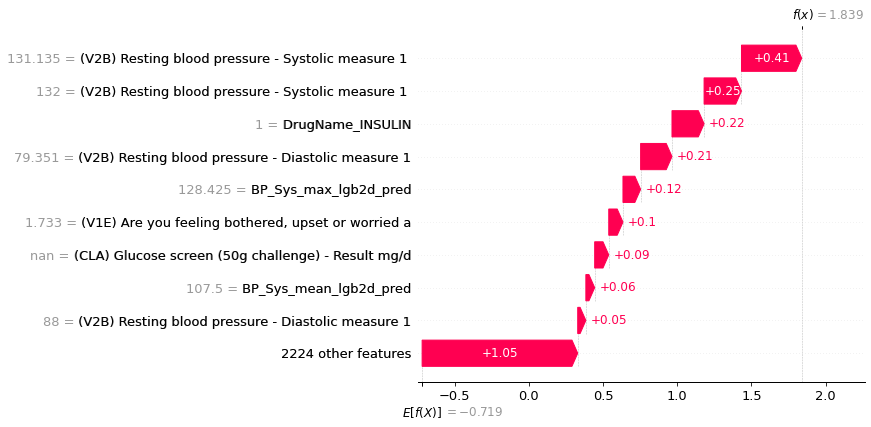

index 1   sort index 1077   y value 248.9


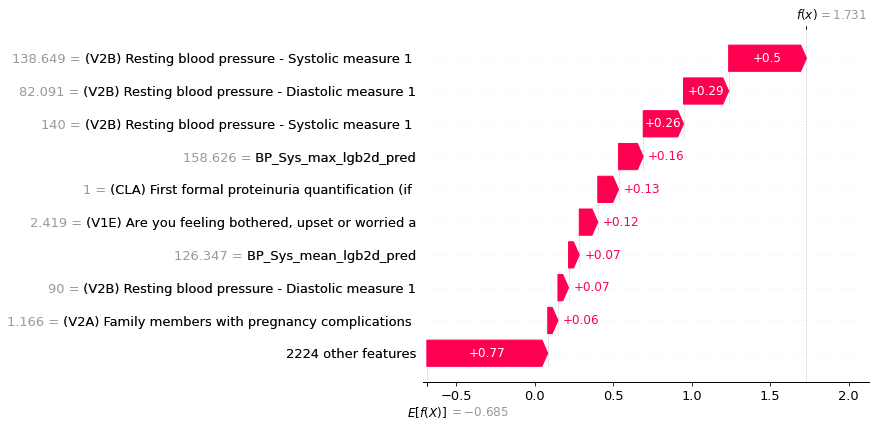

index 2   sort index 3861   y value -269.0


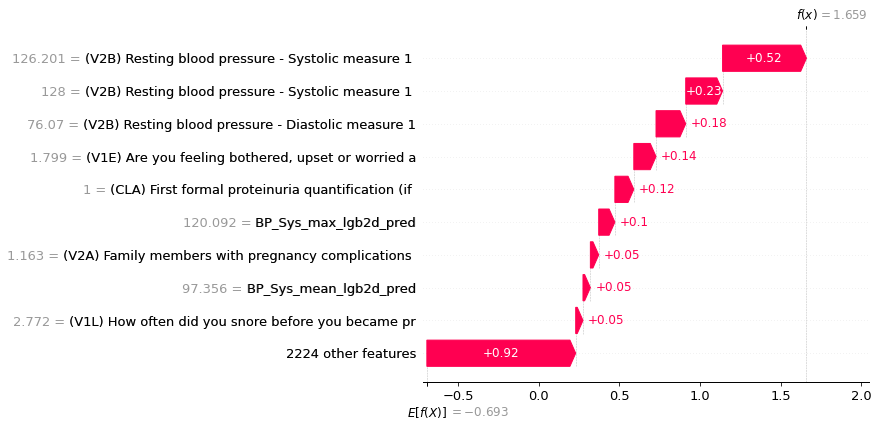

index 3   sort index 7119   y value 262.0


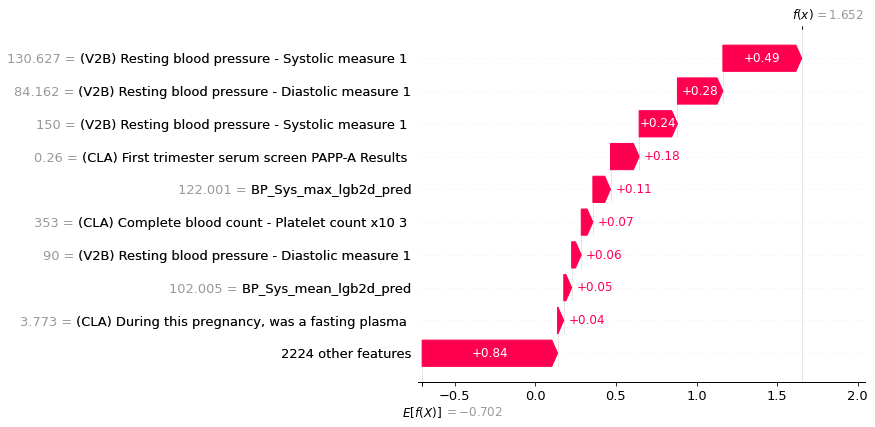

index 4   sort index 3766   y value 232.4


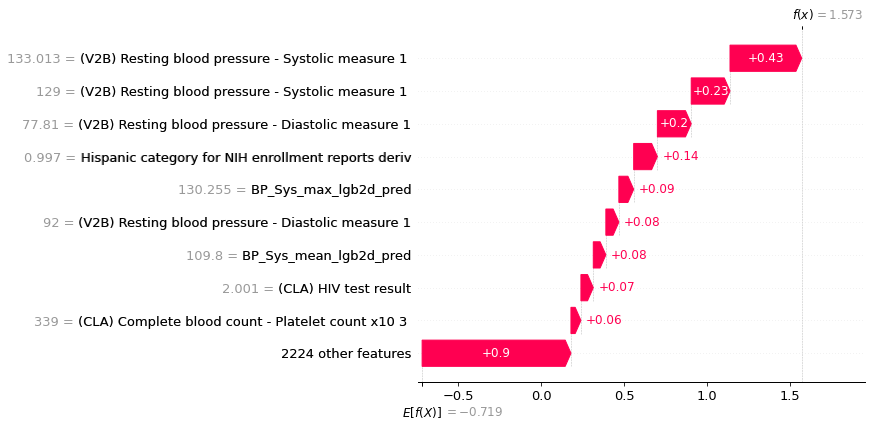

index 5   sort index 4436   y value 250.0


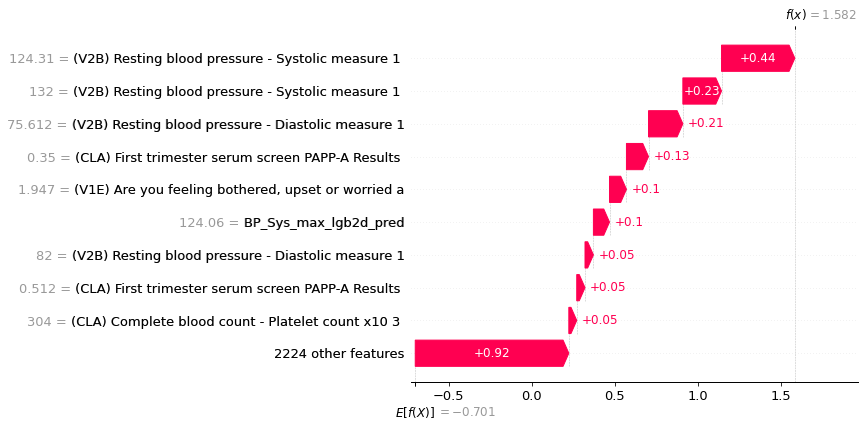

index 6   sort index 8376   y value 164.6


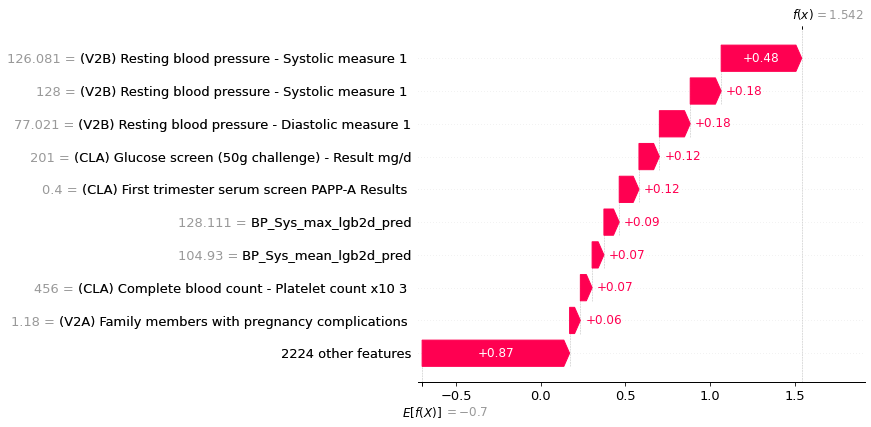

index 7   sort index 6432   y value 266.5


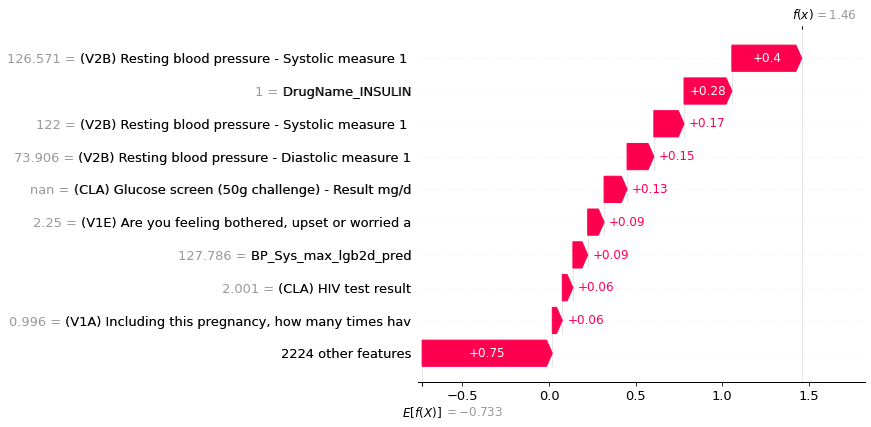

index 8   sort index 5255   y value 115.4


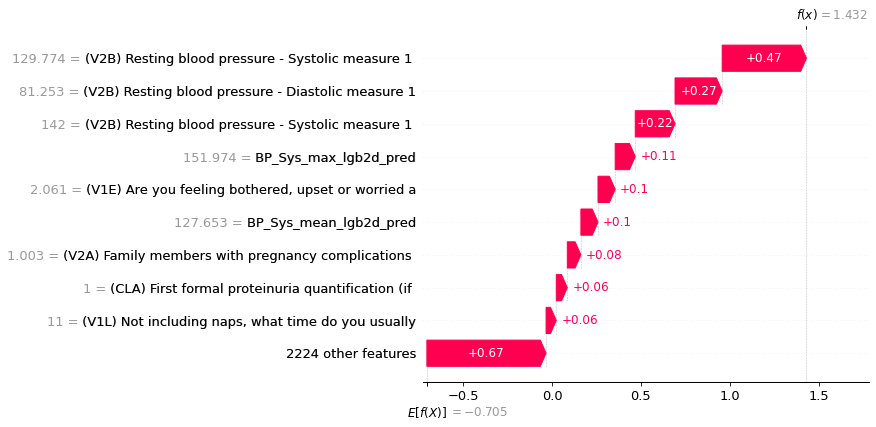

index 9   sort index 6016   y value -249.0


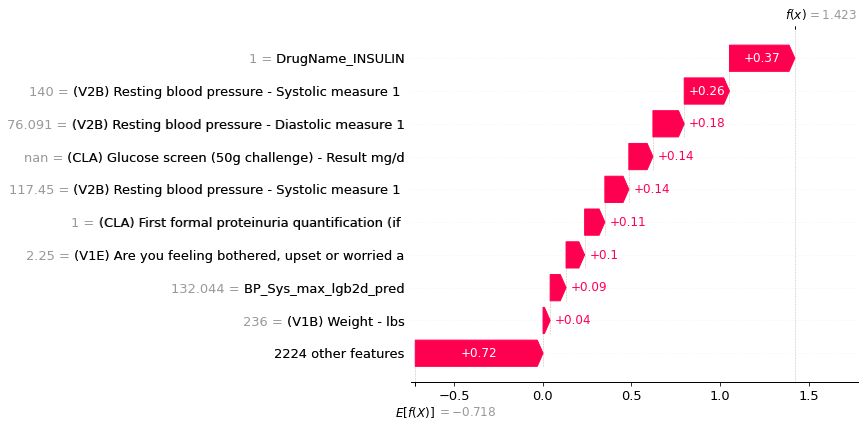

In [344]:
# visualize individual shap waterfall plots, top ten worst risk scores
# each mom has a personalized explanation of her risk score, broken down by all of her risk factors
for i in range(0,10):
    print(f'index {i}   sort index {isort[i]}   y value {y[isort[i]]:.1f}')
    shap.plots.waterfall(shap_values[isort[i]], max_display=10)
    plt.show()

#### Ten best risk scores

index 8640   sort index 7015   y value -291.0


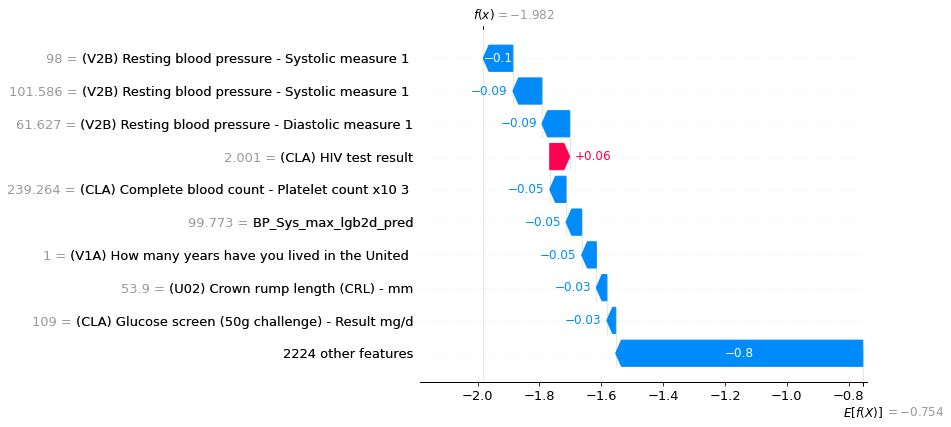

index 8639   sort index 4930   y value -276.0


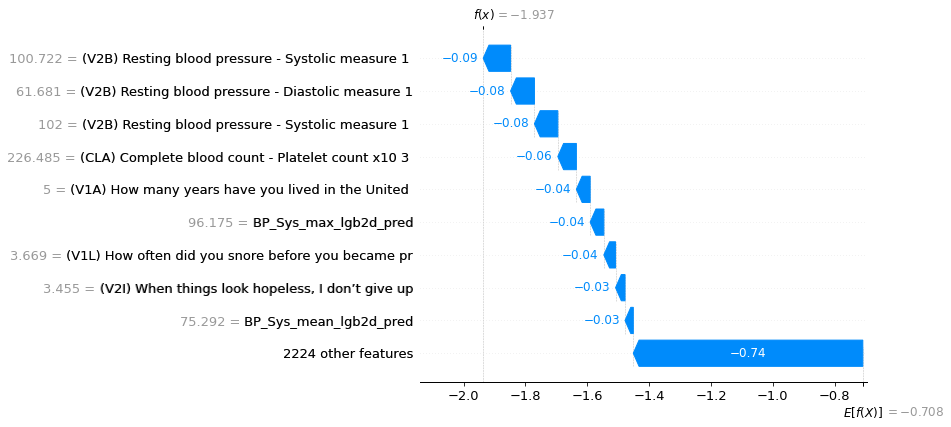

index 8638   sort index 293   y value -275.0


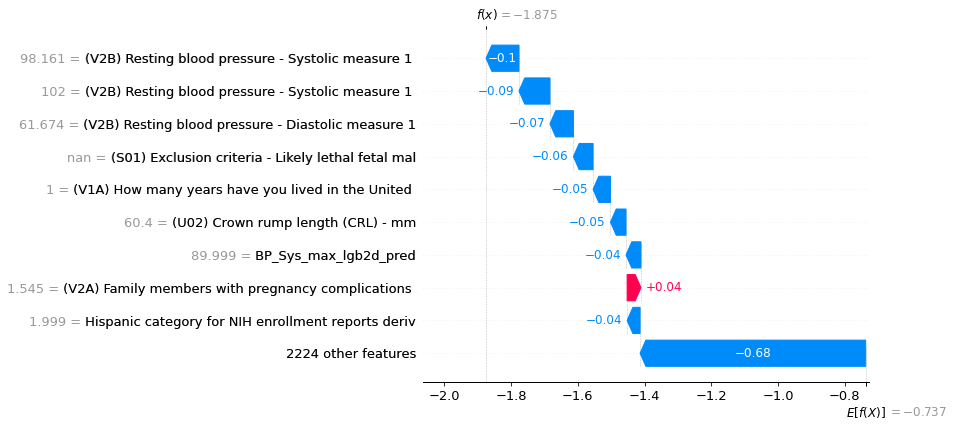

index 8637   sort index 1374   y value -276.0


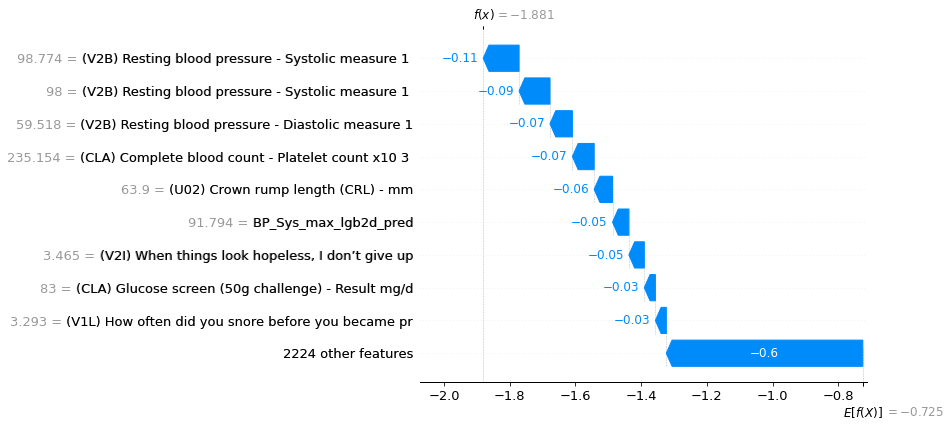

index 8636   sort index 3153   y value -289.0


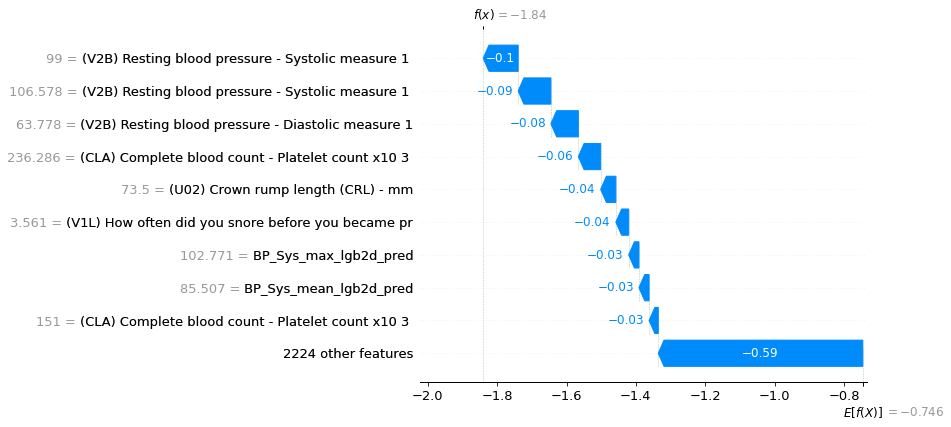

index 8635   sort index 2170   y value -278.0


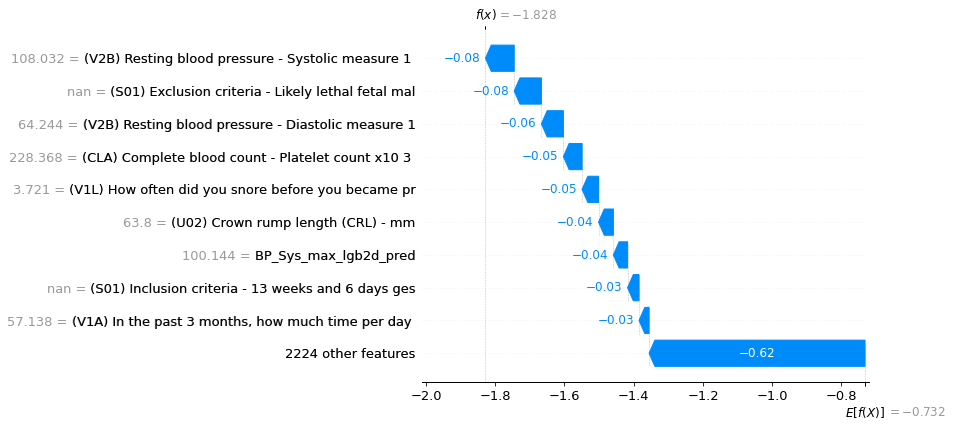

index 8634   sort index 6020   y value -281.0


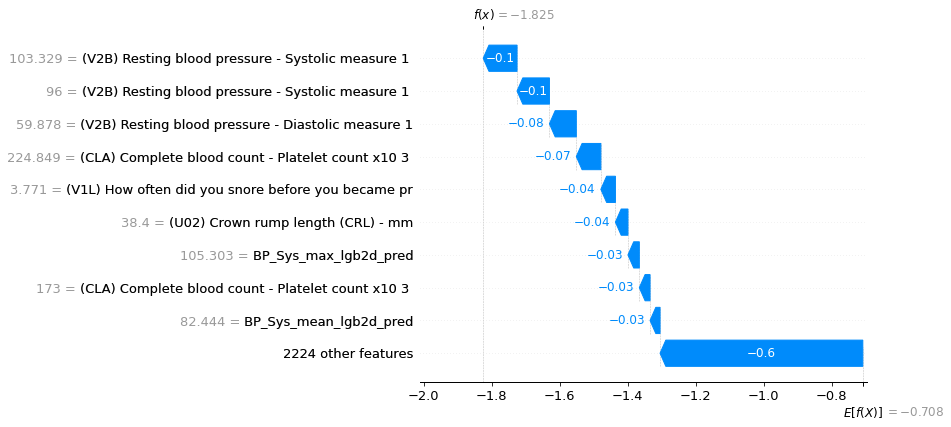

index 8633   sort index 4627   y value -282.0


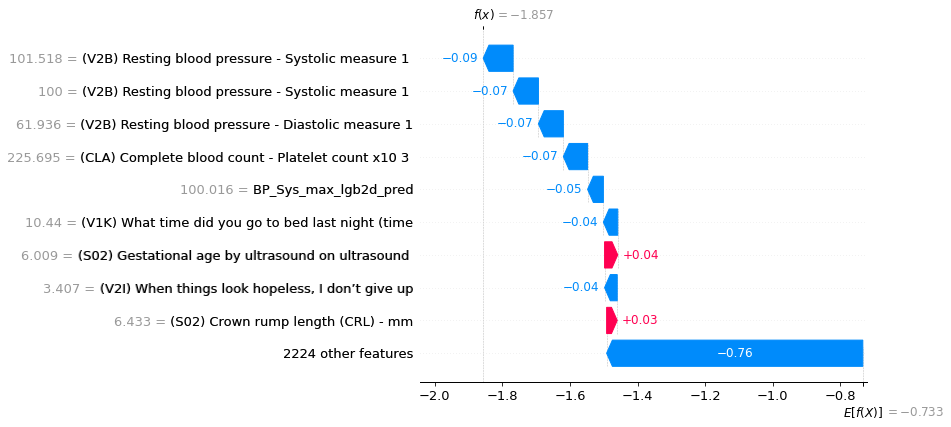

index 8632   sort index 7802   y value -275.0


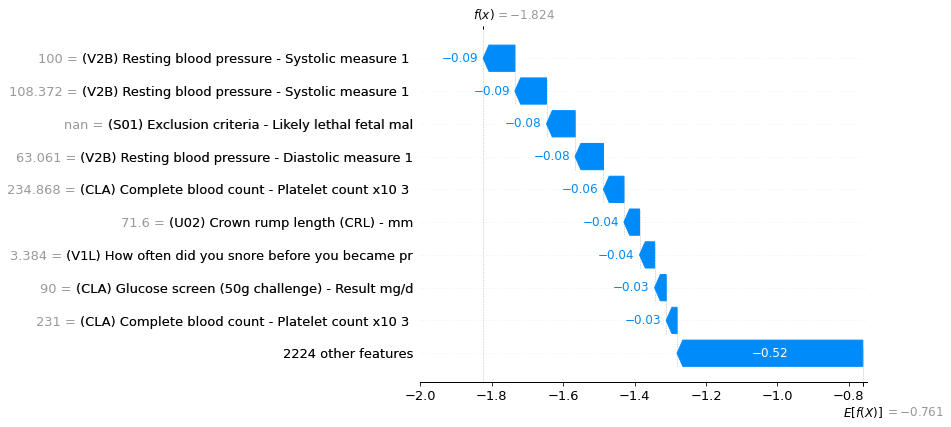

index 8631   sort index 2445   y value -286.0


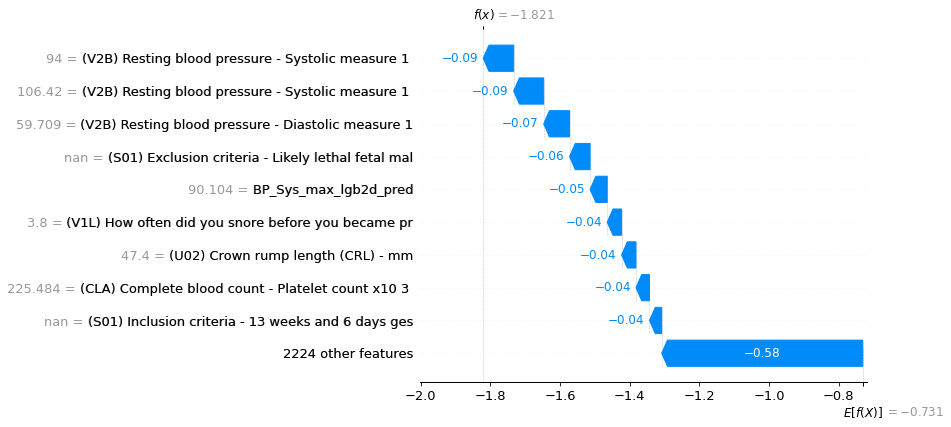

In [345]:
# visualize individual shap explanations, ten best risk scores
ls = len(shap_values)
for i in range(ls-1,ls-11,-1):
    print(f'index {i}   sort index {isort[i]}   y value {y[isort[i]]:.1f}')
    shap.plots.waterfall(shap_values[isort[i]], max_display=10)
    plt.show()

#### Ten evenly sampled across the whole range of risk scores

index 0   sort index 6096   y value -254.0


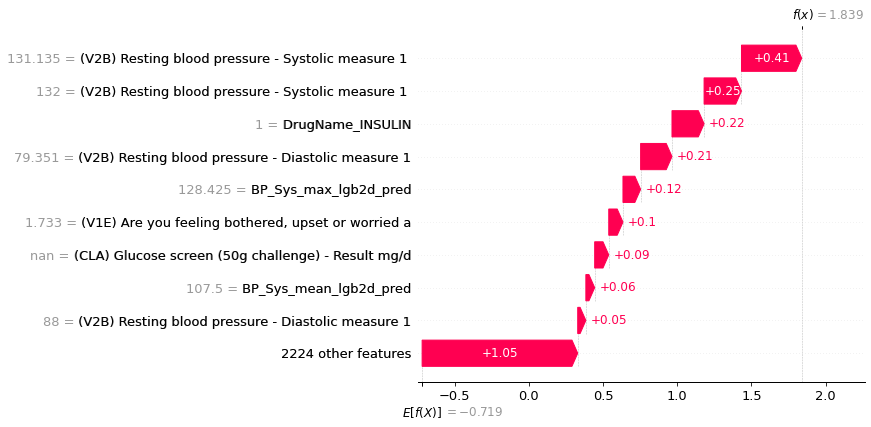

index 200   sort index 1425   y value -279.0


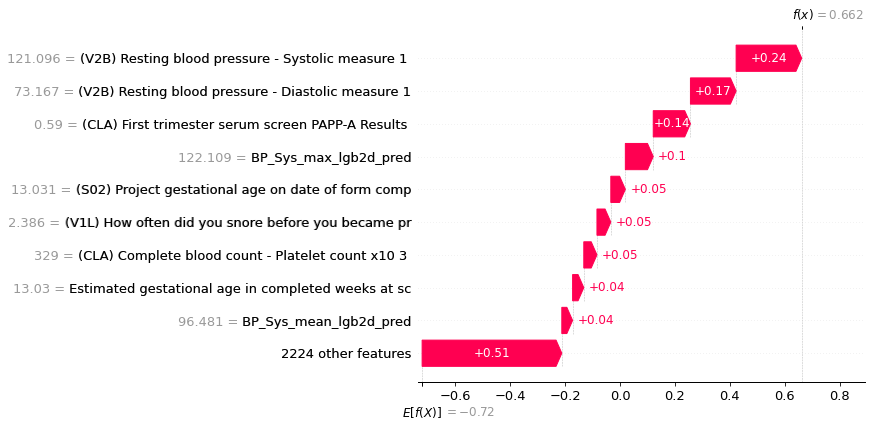

index 400   sort index 6507   y value -276.0


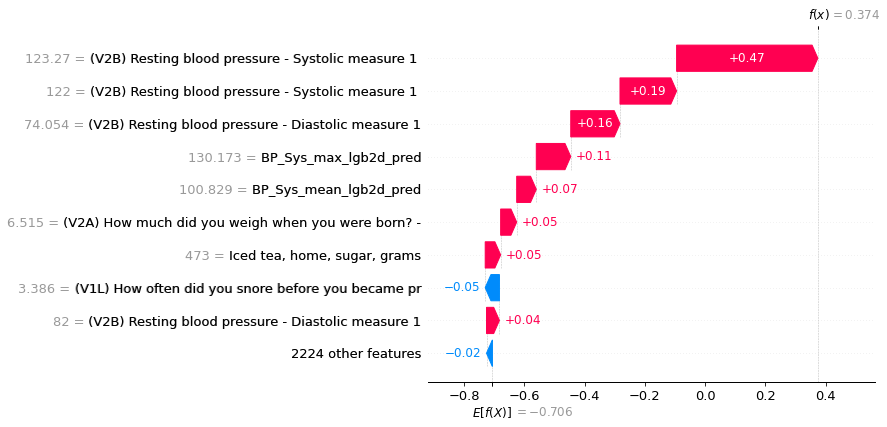

index 600   sort index 1144   y value 269.3


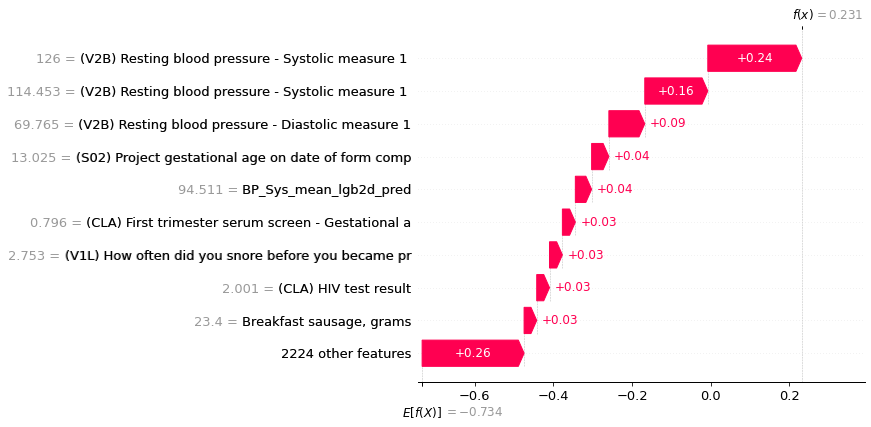

index 800   sort index 4056   y value 231.7


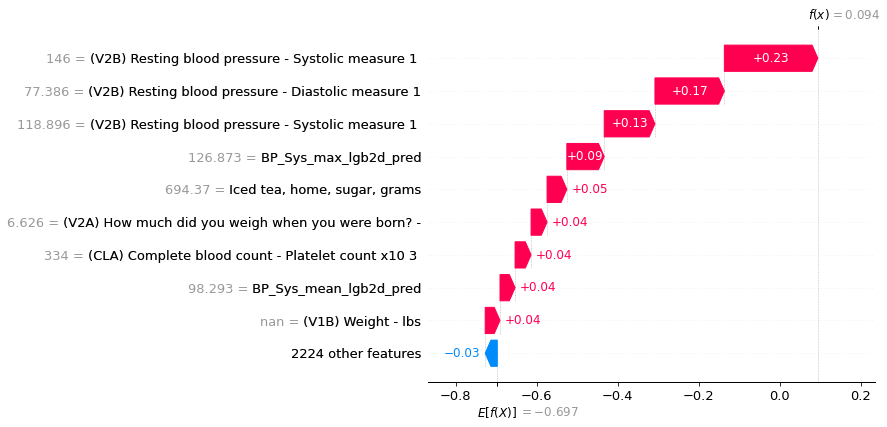

index 1000   sort index 7093   y value 266.5


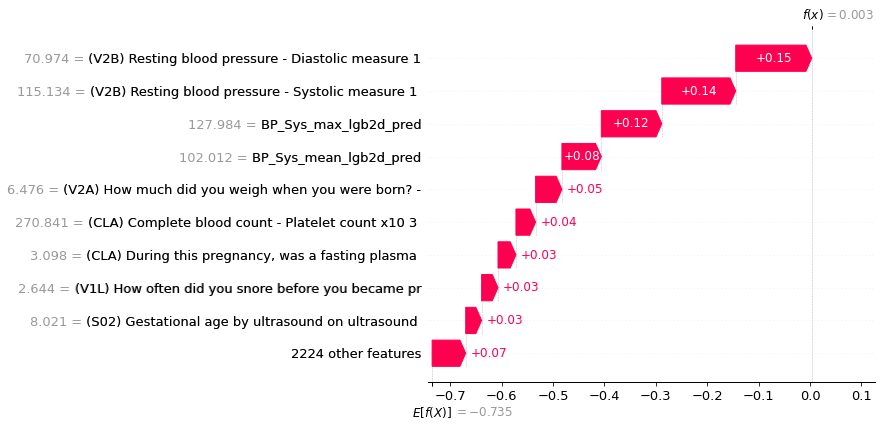

index 1200   sort index 2970   y value 217.0


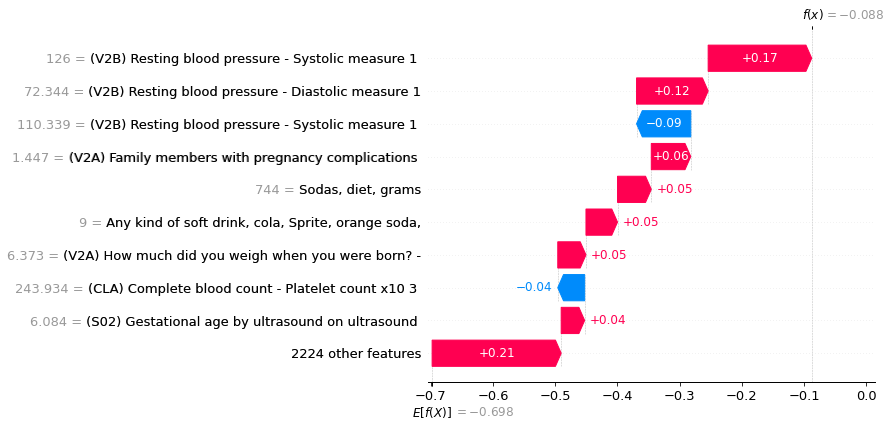

index 1400   sort index 4579   y value 145.0


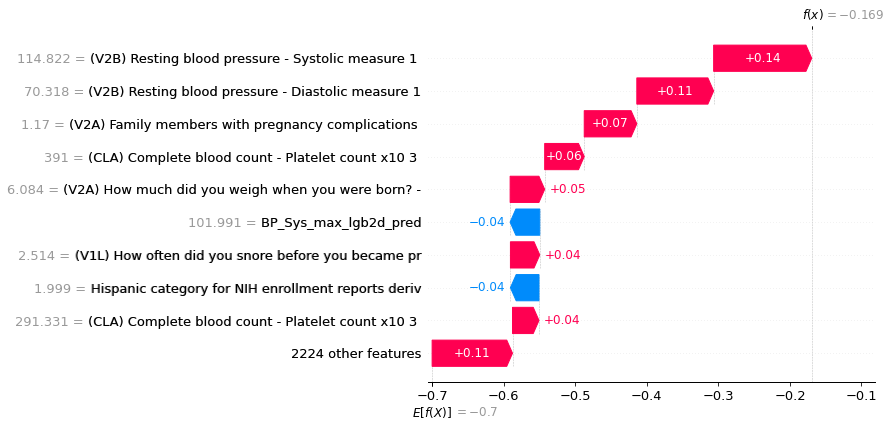

index 1600   sort index 1217   y value 252.3


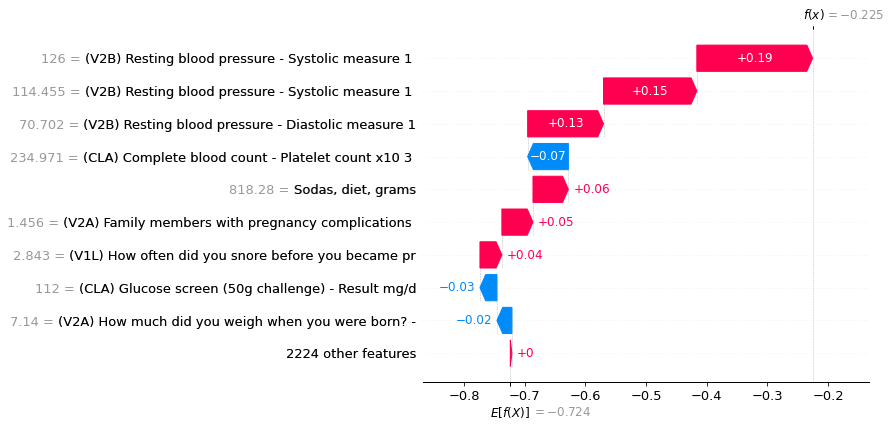

index 1800   sort index 4429   y value -274.0


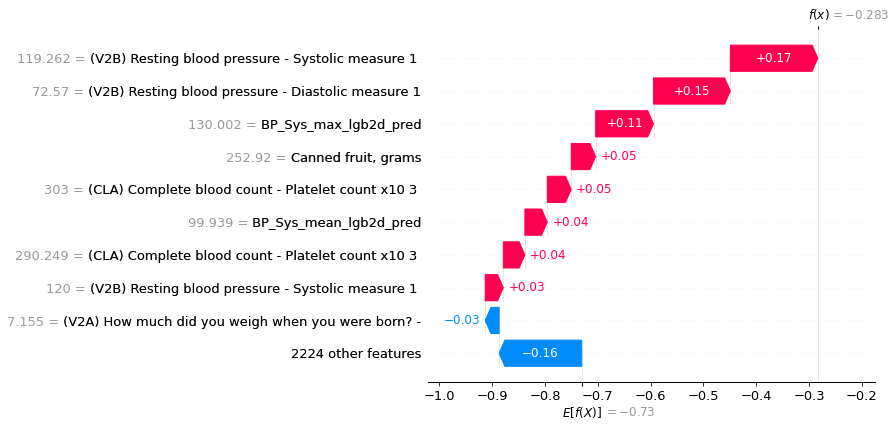

index 2000   sort index 3122   y value -232.0


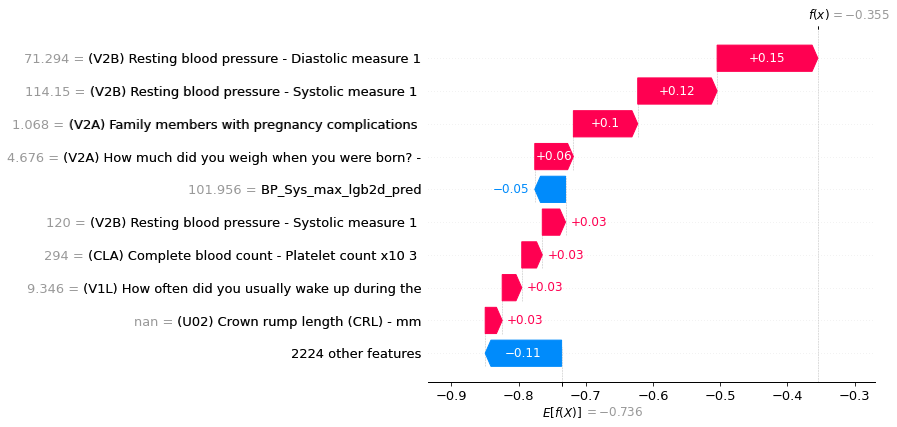

index 2200   sort index 2158   y value -282.0


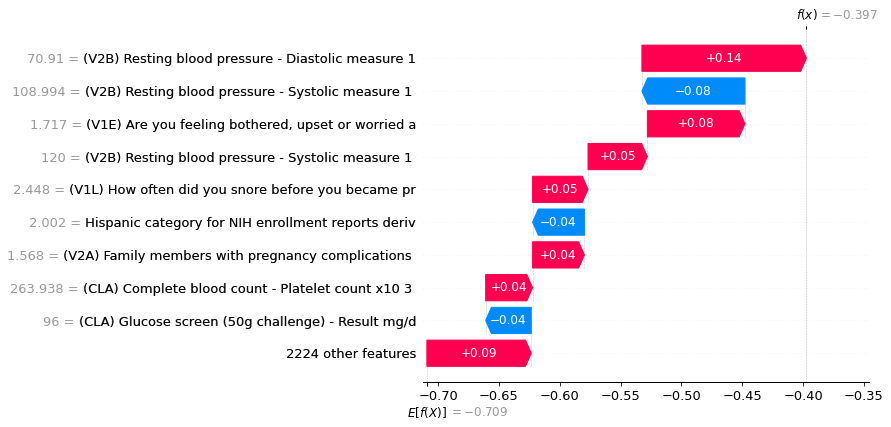

index 2400   sort index 6470   y value 248.8


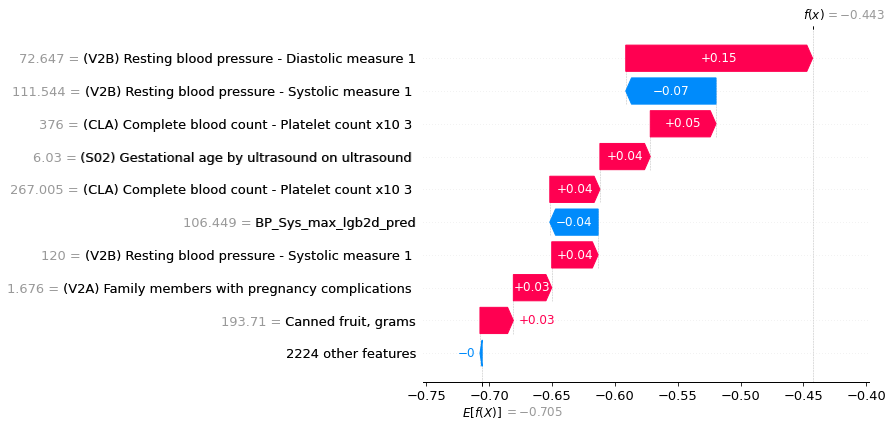

index 2600   sort index 5104   y value -268.0


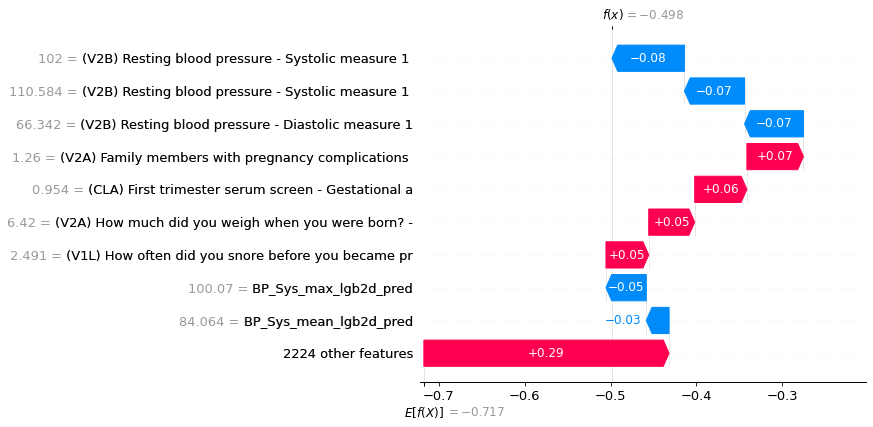

index 2800   sort index 6965   y value -274.0


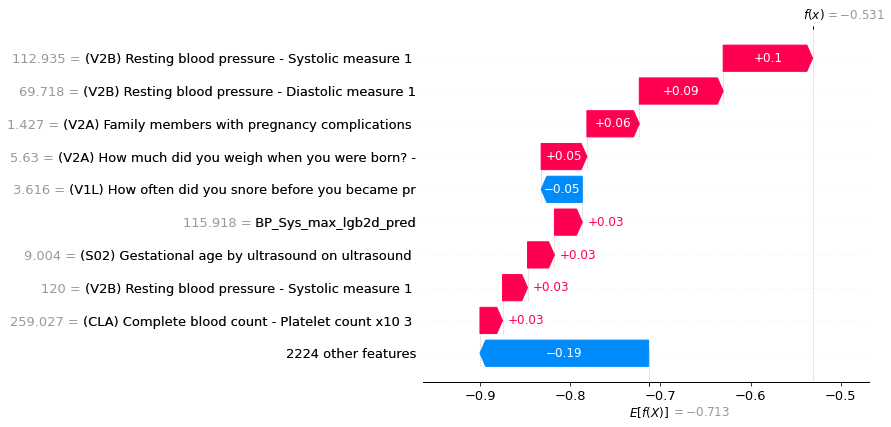

index 3000   sort index 331   y value 203.0


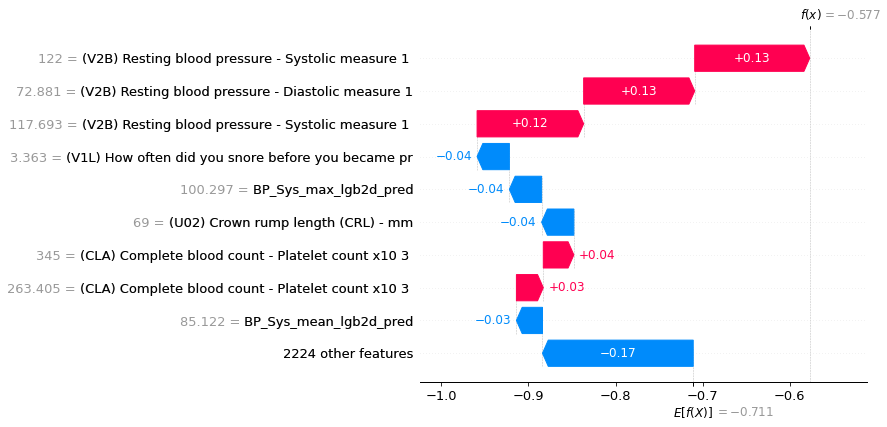

index 3200   sort index 1832   y value -279.0


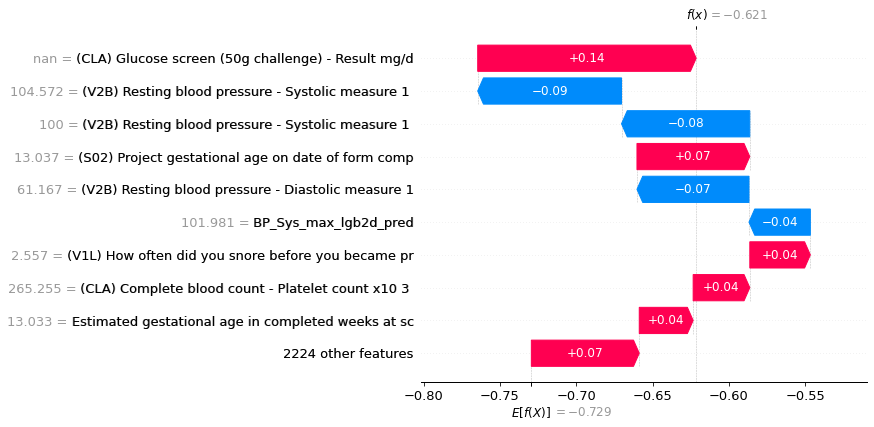

index 3400   sort index 6561   y value -273.0


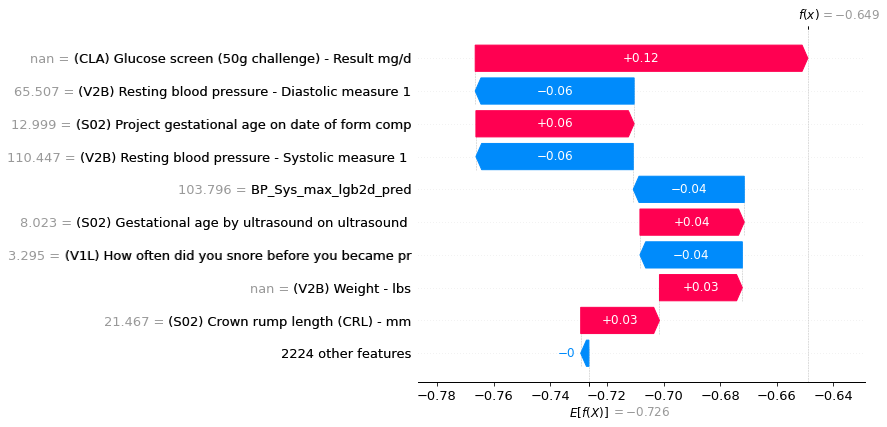

index 3600   sort index 216   y value 282.2


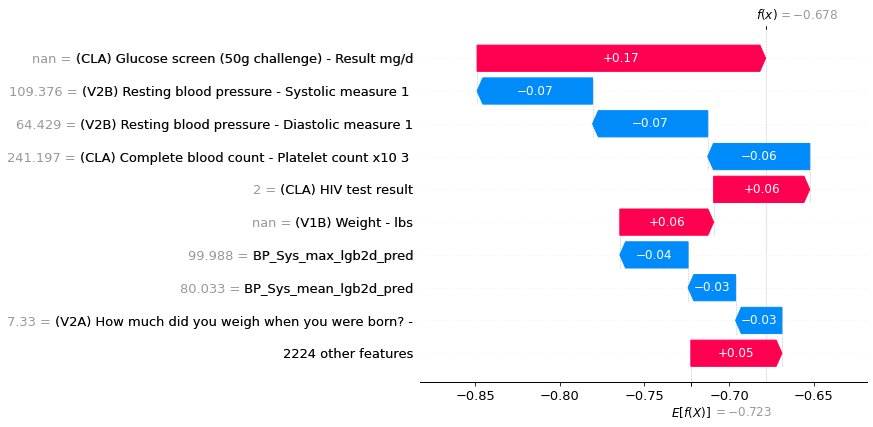

index 3800   sort index 3773   y value -287.0


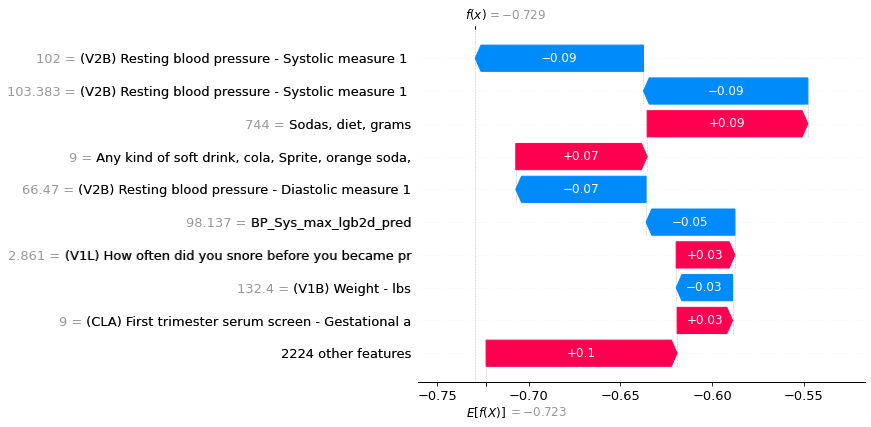

index 4000   sort index 1238   y value -272.0


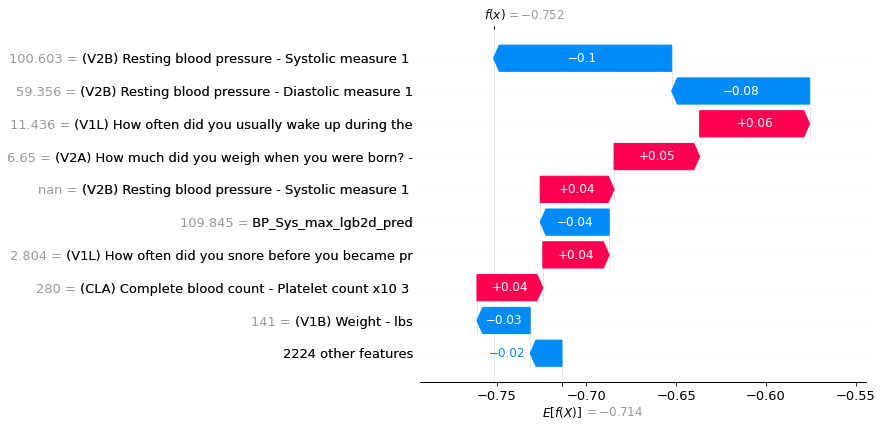

index 4200   sort index 1101   y value -284.0


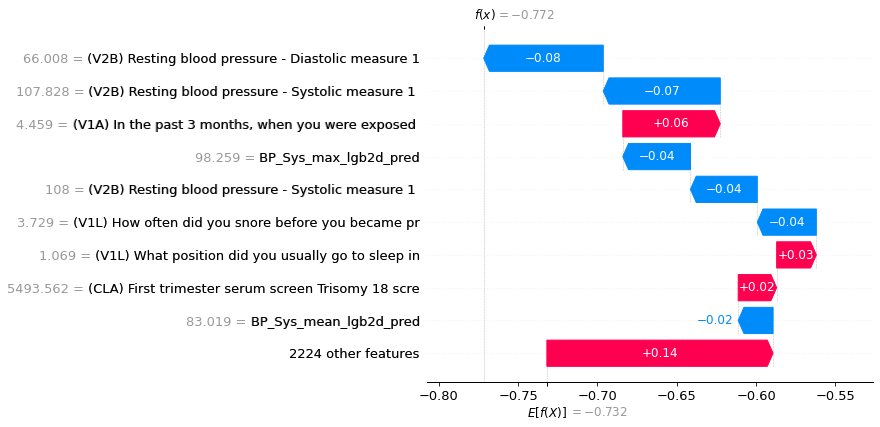

index 4400   sort index 1580   y value -274.0


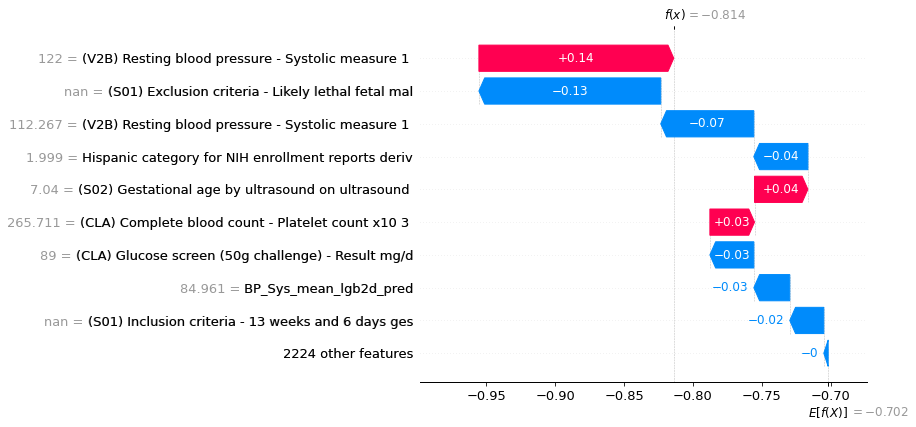

index 4600   sort index 3547   y value -296.0


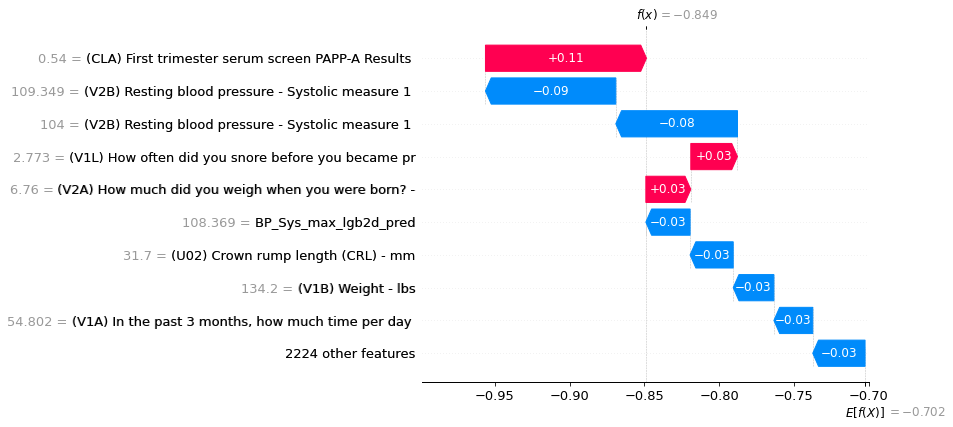

index 4800   sort index 3395   y value -282.0


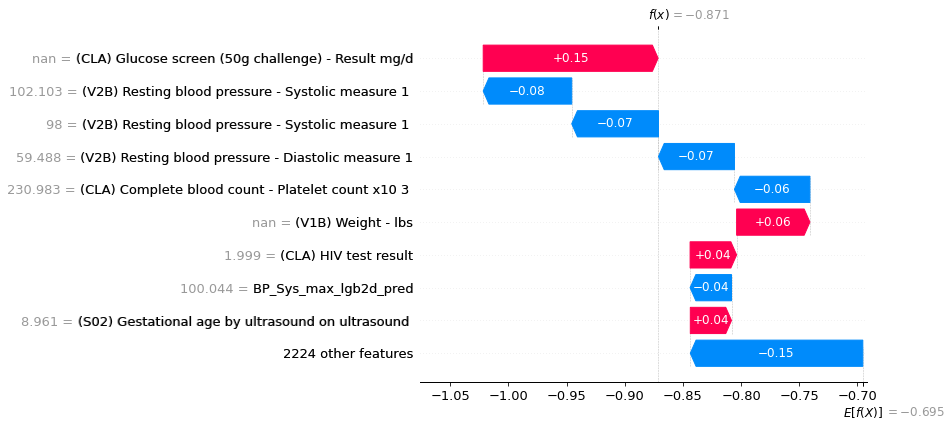

index 5000   sort index 503   y value -277.0


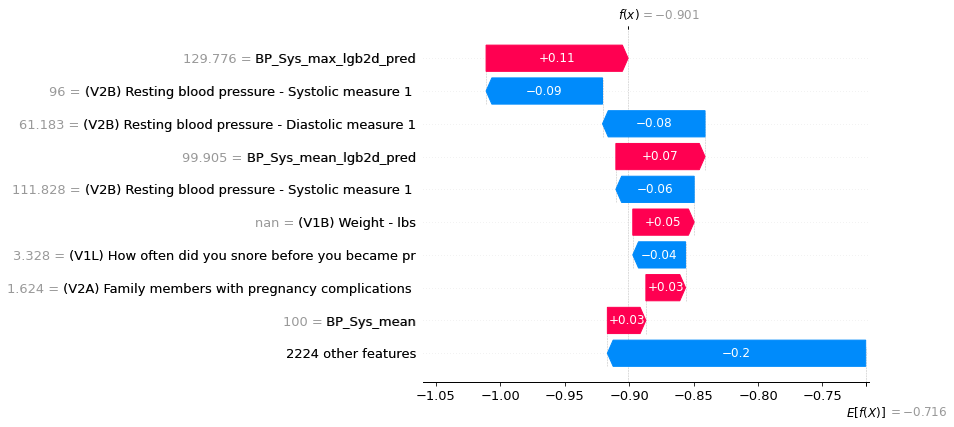

index 5200   sort index 7354   y value -286.0


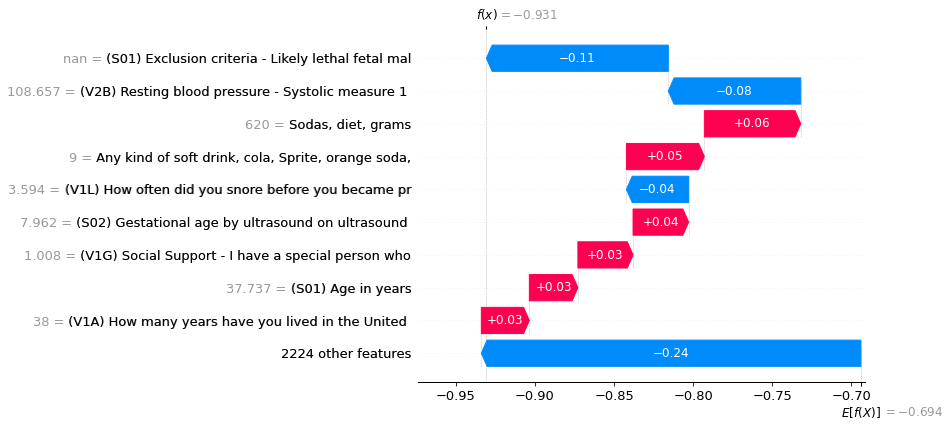

index 5400   sort index 6732   y value 289.3


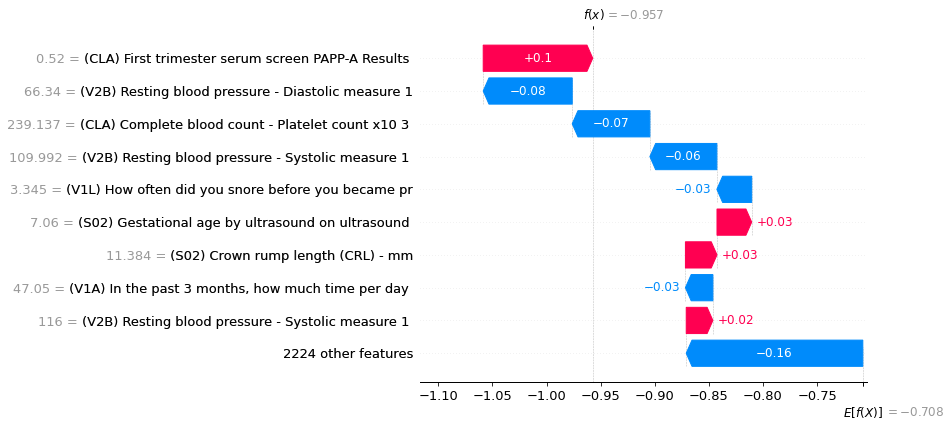

index 5600   sort index 5885   y value -266.0


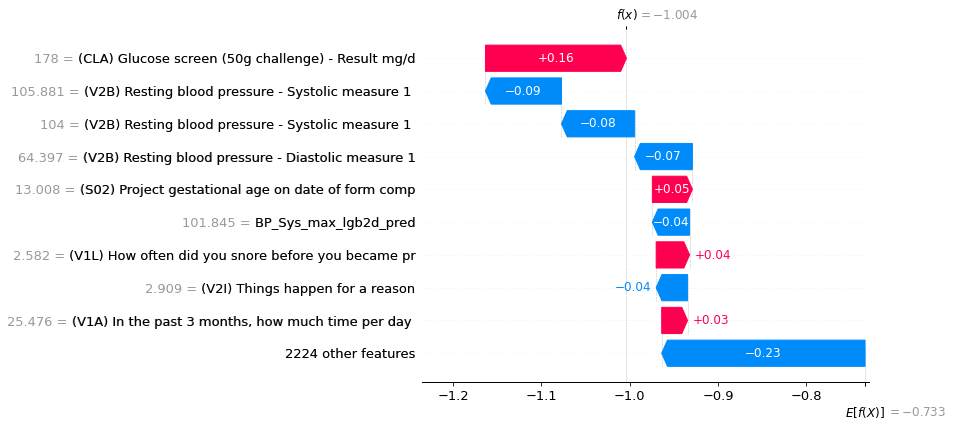

index 5800   sort index 7911   y value -287.0


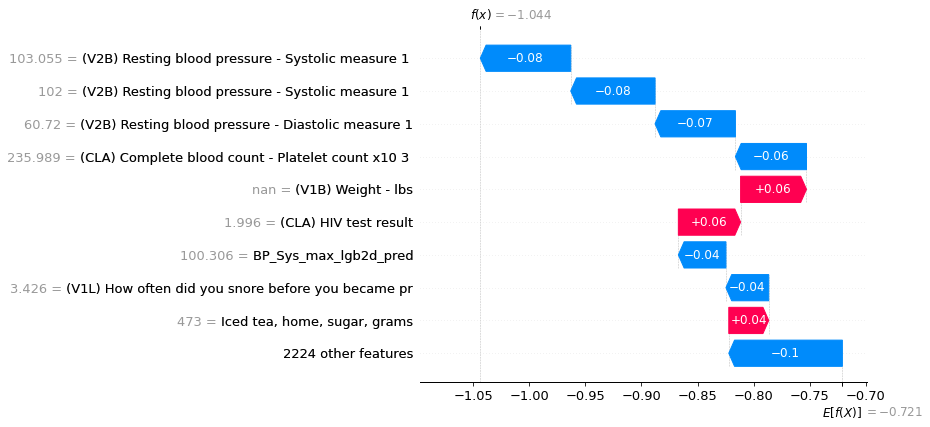

index 6000   sort index 5526   y value 252.2


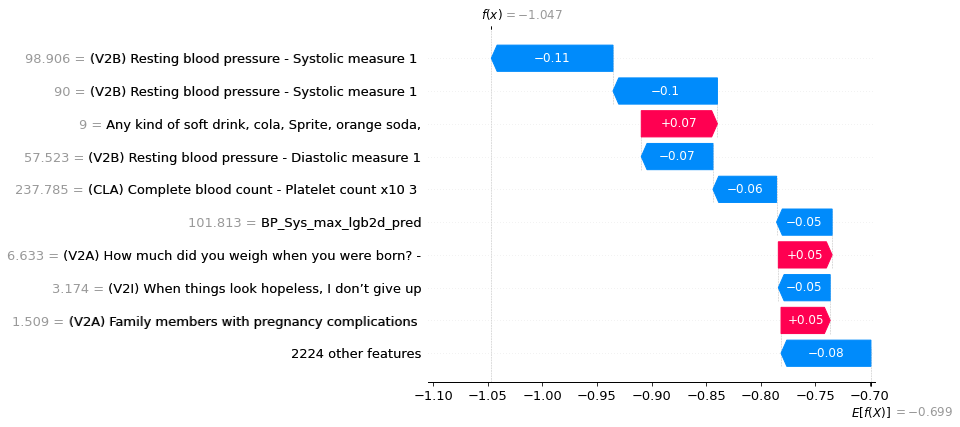

index 6200   sort index 8576   y value -269.0


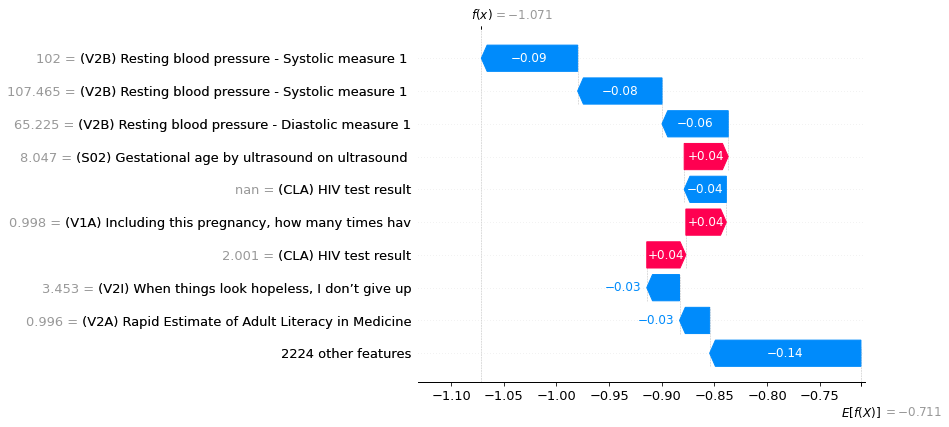

index 6400   sort index 8076   y value 272.8


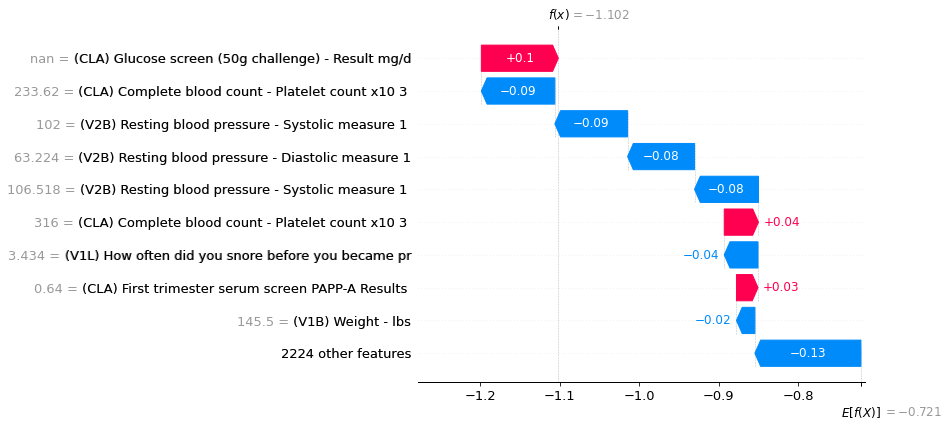

index 6600   sort index 7256   y value -282.0


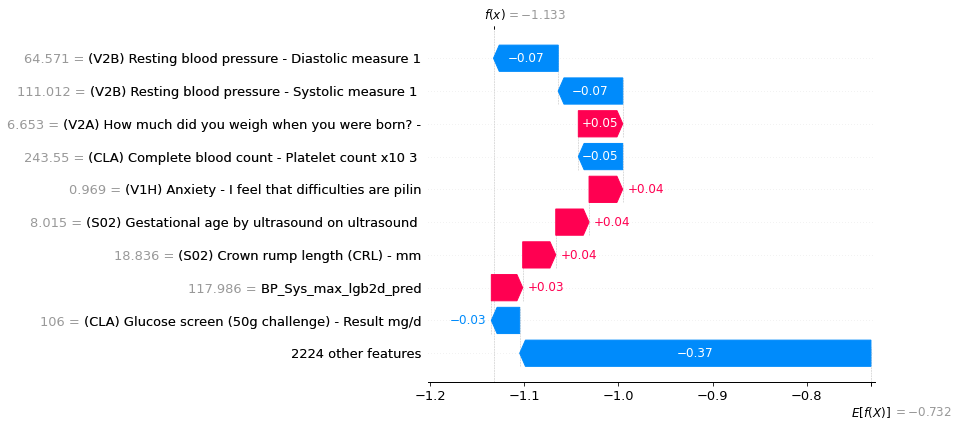

index 6800   sort index 441   y value -273.0


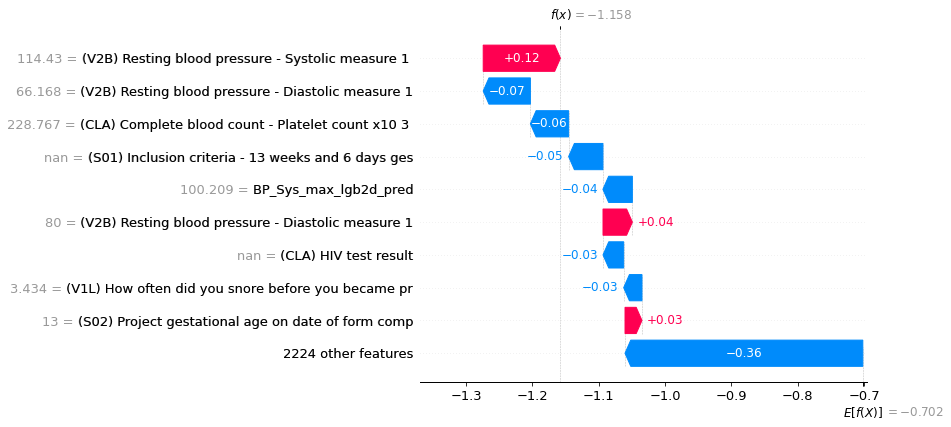

index 7000   sort index 1915   y value -283.0


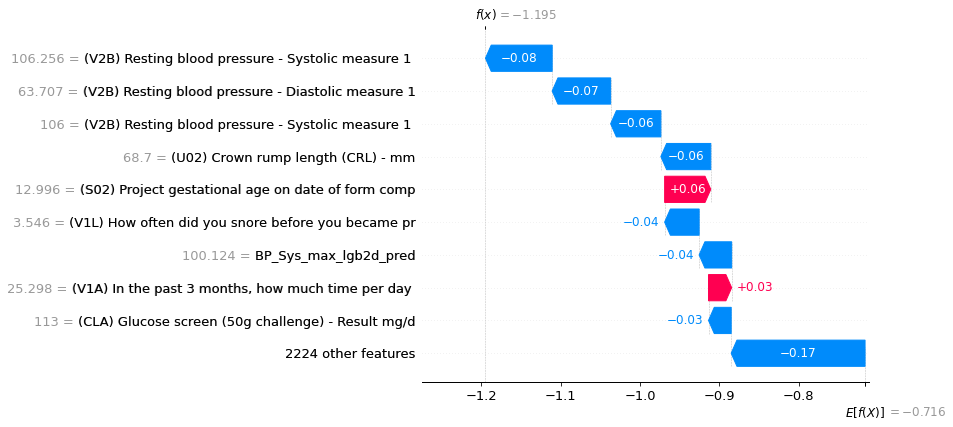

index 7200   sort index 6284   y value 218.5


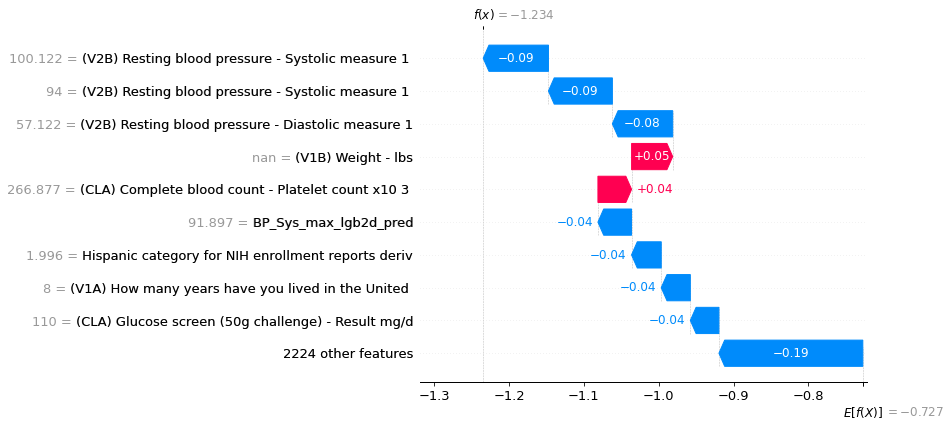

index 7400   sort index 2669   y value -270.0


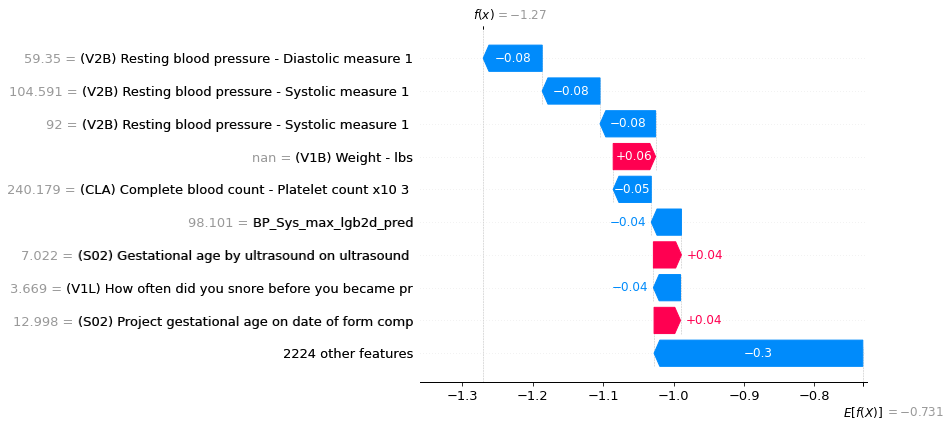

index 7600   sort index 502   y value -257.0


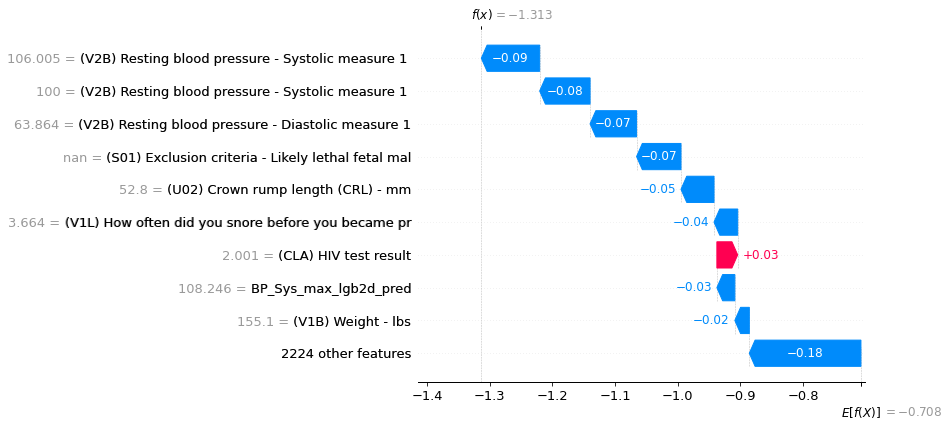

index 7800   sort index 489   y value -254.0


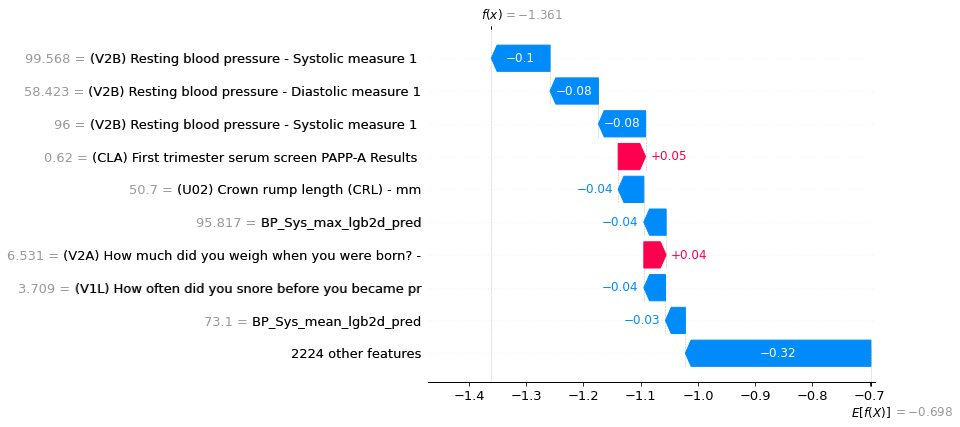

index 8000   sort index 2112   y value -288.0


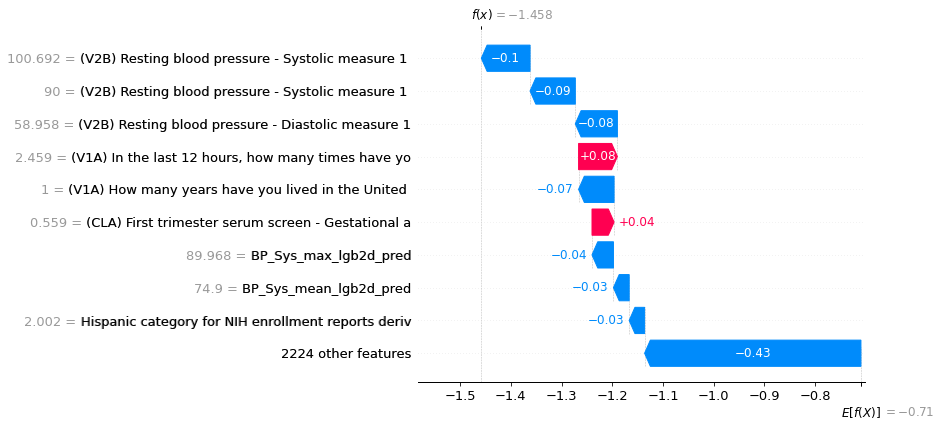

index 8200   sort index 7353   y value 291.5


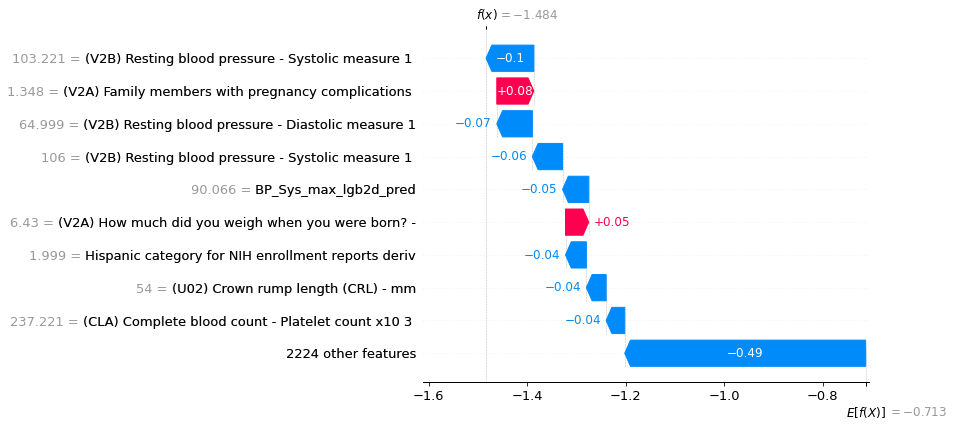

index 8400   sort index 7909   y value -279.0


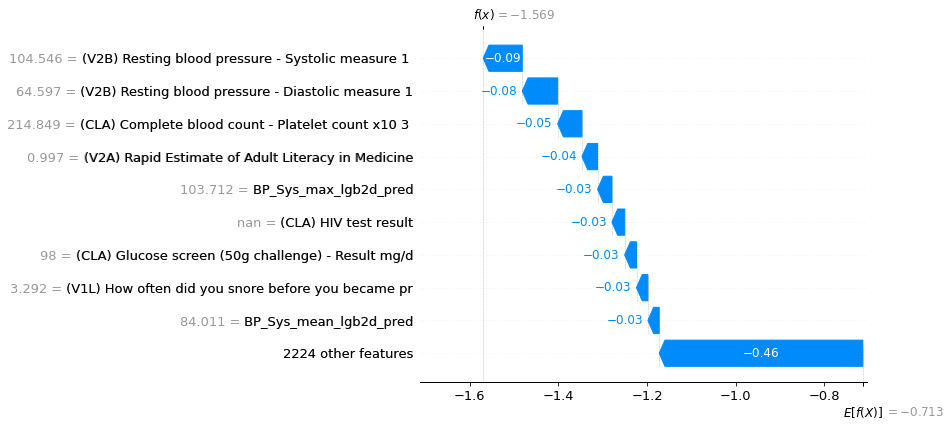

index 8600   sort index 4478   y value -276.0


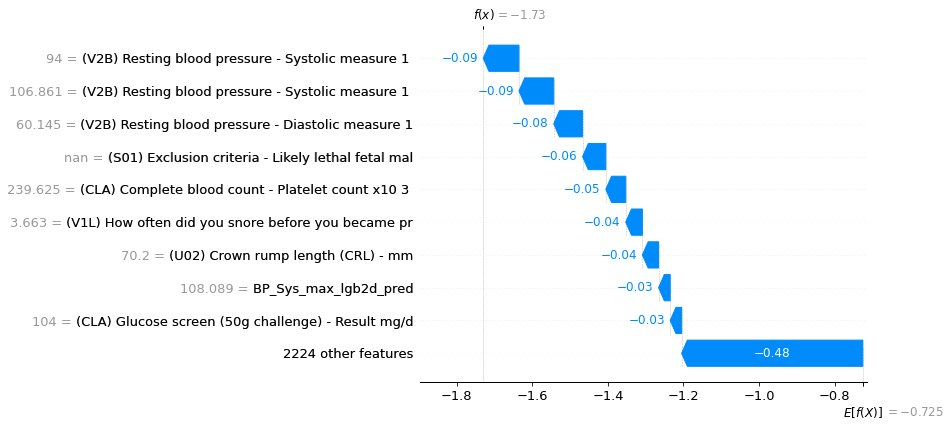

In [346]:
# visualize individual shap explanations, evenly sampled across the whole range of risk scores
for i in range(0,ls,200):
    print(f'index {i}   sort index {isort[i]}   y value {y[isort[i]]:.1f}')
    shap.plots.waterfall(shap_values[isort[i]], max_display=10)
    plt.show()

In [347]:
# visualize the first prediction's explanation with a force plot
# shap.plots.force(shap_values[0])

In [348]:
# visualize all the training set predictions
# shap.plots.force(explainer.expected_value, shap_values)

In [350]:
# create a dependence scatter plot to show the effect of a single feature across the whole dataset
# shap.plots.scatter(shap_values[:,"BMI"], color=shap_values)

#### Population-level variable effects

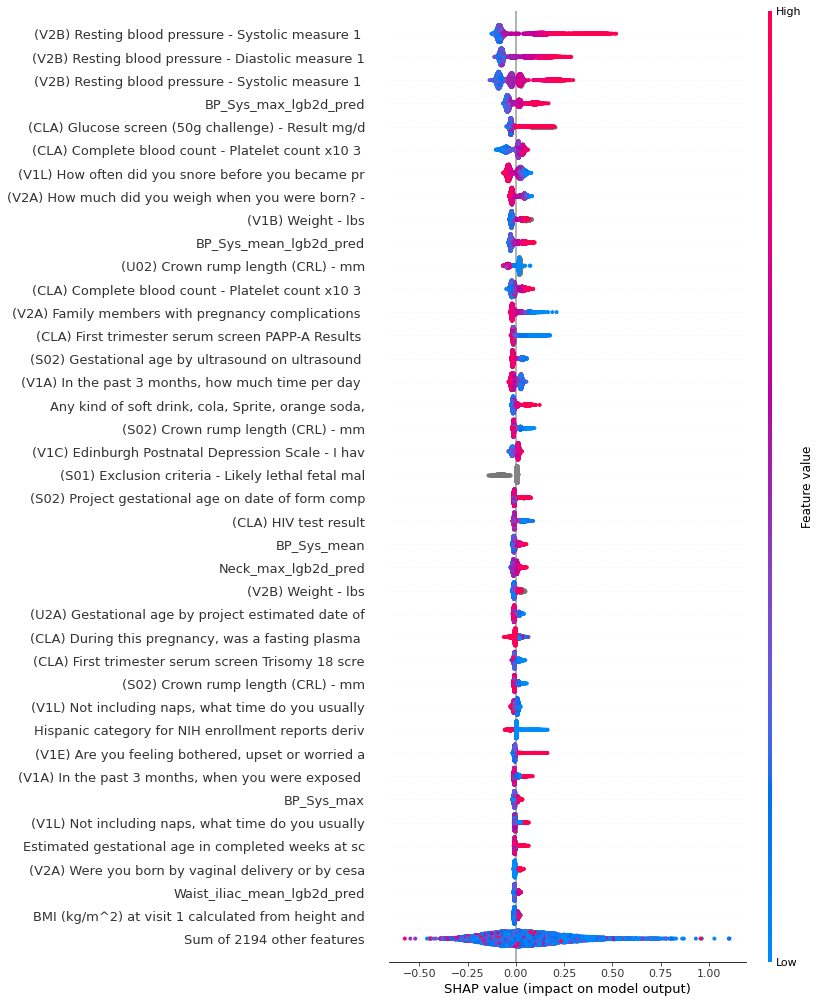

In [349]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values, max_display=40)